In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
from scipy import stats
import time

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'

In [4]:
training_index_start = 0
training_index_end = 669

In [5]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [6]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [7]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [8]:
def make_scatter(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, do_log_log:bool=False, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.scatter(  depytorch( xvalues.flatten() ), depytorch( yvalues.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    if do_log_log:
        axs.set_xscale('log')
        axs.set_yscale('log')
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [9]:
def make_scatter_with_handle(axs, xvalues:torch.Tensor, yvalues:torch.Tensor, label:str):
    axs.scatter(  depytorch( xvalues.flatten() ), depytorch( yvalues.flatten() ), label=label  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )

In [10]:
def make_errorbar(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, yerrs:torch.Tensor, y_bounds=None, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    x_flat = depytorch( xvalues.flatten() )
    y_flat = depytorch( yvalues.flatten() )
    axs.errorbar(  x=x_flat, y=y_flat, yerr=depytorch( yerrs.flatten() ), color='red', ecolor='blue'  )
    # axs.plot(x_flat, y_flat, color='red', label='mean', linewidth=10, fillstyle='full')
    if type(y_bounds) != type(None):
        axs.set_ylim(y_bounds)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.legend()
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [11]:
def make_errorbar_with_handle(axs, xvalues:torch.Tensor, yvalues:torch.Tensor, yerrs:torch.Tensor, label:str):
    axs.errorbar(  x=depytorch( xvalues.flatten() ), y=depytorch( yvalues.flatten() ), yerr=depytorch( yerrs.flatten() ), label=label  )

In [12]:
def make_errorbar_two_sides(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, y_bounds=None, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    y_middle = yvalues[:,1]
    y_low = y_middle - yvalues[:,0]
    y_high = yvalues[:,2] - y_middle
    y_err = torch.stack( (y_low,y_high), dim=0 )
    axs.errorbar(  x=depytorch(xvalues), y=depytorch(y_middle), yerr=depytorch(y_err), color='red', ecolor='blue'  )
    # axs.plot(x_flat, y_flat, color='red', label='mean', linewidth=10, fillstyle='full')
    if type(y_bounds) != type(None):
        axs.set_ylim(y_bounds)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.legend()
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [13]:
def show_square(values:torch.Tensor, width:int=10, height:int=10):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(width, height) )
    cbax = axs.imshow( depytorch(values) )
    fig.colorbar(cbax, shrink=0.8)

In [14]:
def get_values_for_counts(counts:torch.Tensor):
    return torch.arange( start=1, end=counts.size(dim=-1)+1, dtype=float_type, device=device )

In [15]:
def make_scatter_and_line(xname:str, xvalues:torch.Tensor, yname:str, scatter_label:str, y_scatter_values:torch.Tensor, line_label:str, y_line_values:torch.Tensor, do_log_log:bool=False, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    x_np = depytorch( xvalues.flatten() )
    axs.scatter(  x_np, depytorch( y_scatter_values.flatten() ), label=scatter_label  )
    axs.plot(  x_np, depytorch( y_line_values.flatten() ), label=line_label  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    if do_log_log:
        axs.set_xscale('log')
        axs.set_yscale('log')
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    axs.legend()
    plt.show()
    if save:
        plt.savefig(file_name)

In [16]:
def make_histograms_for_rows(name:str, row_names:list, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    num_hists = values.size(dim=0)
    for row in range(num_hists):
        axs.hist( depytorch(values[row,:]), label=row_names[row] )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.legend()
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [17]:
# example file branching_parameter_minus_1_all_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
num_thresholds = 161
min_threshold = 0
max_threshold = 4
max_x_min = 2# 10
num_passes = 10
num_tries_per_pass = 10
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
file_suffix = f'all_thresholds_{num_thresholds}_from_{min_threshold:.3g}_to_{max_threshold:.3g}_maxxmin_{max_x_min}_passes_{num_passes}_tries_{num_tries_per_pass}'
branching_parameters = 1 + torch.load( os.path.join(file_dir, f'branching_parameter_minus_1_{file_suffix}.pt') )
print( 'branching_parameters size', branching_parameters.size() )
gap_duration_counts = torch.load( os.path.join(file_dir, f'gap_duration_counts_{file_suffix}.pt') )
gap_durations = get_values_for_counts(counts=gap_duration_counts)
print( 'gap_duration_counts size', gap_duration_counts.size() )
duration_counts = torch.load( os.path.join(file_dir, f'duration_counts_{file_suffix}.pt') )
durations = get_values_for_counts(counts=duration_counts)
print( 'duration_counts size', duration_counts.size() )
size_counts = torch.load( os.path.join(file_dir, f'size_counts_{file_suffix}.pt') )
sizes = get_values_for_counts(counts=size_counts)
print( 'size_counts size', size_counts.size() )
mean_size_for_duration = torch.load( os.path.join(file_dir, f'mean_size_for_duration_{file_suffix}.pt') )
durations_for_mean_size = get_values_for_counts(counts=mean_size_for_duration)
print( 'mean_size_for_duration size', mean_size_for_duration.size() )

branching_parameters size torch.Size([161, 2680])
gap_duration_counts size torch.Size([161, 1191])
duration_counts size torch.Size([161, 1157])
size_counts size torch.Size([161, 11632])
mean_size_for_duration size torch.Size([161, 1157])


In [18]:
# example file branching_parameter_minus_1_all_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
perm_index = 1
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
perm_file_suffix = f'all_perm_{perm_index}_thresholds_{num_thresholds}_from_{min_threshold:.3g}_to_{max_threshold:.3g}_maxxmin_{max_x_min}_passes_{num_passes}_tries_{num_tries_per_pass}'
branching_parameters_perm = 1 + torch.load( os.path.join(file_dir, f'branching_parameter_minus_1_{perm_file_suffix}.pt') )
print( 'branching_parameters_perm size', branching_parameters_perm.size() )
gap_duration_counts_perm = torch.load( os.path.join(file_dir, f'gap_duration_counts_{perm_file_suffix}.pt') )
gap_durations_perm = get_values_for_counts(counts=gap_duration_counts_perm)
print( 'gap_duration_counts_perm size', gap_duration_counts_perm.size() )
duration_counts_perm = torch.load( os.path.join(file_dir, f'duration_counts_{perm_file_suffix}.pt') )
durations_perm = get_values_for_counts(counts=duration_counts_perm)
print( 'duration_counts_perm size', duration_counts_perm.size() )
size_counts_perm = torch.load( os.path.join(file_dir, f'size_counts_{perm_file_suffix}.pt') )
sizes_perm = get_values_for_counts(counts=size_counts_perm)
print( 'size_counts_perm size', size_counts_perm.size() )
mean_size_for_duration_perm = torch.load( os.path.join(file_dir, f'mean_size_for_duration_{perm_file_suffix}.pt') )
durations_for_mean_size_perm = get_values_for_counts(counts=mean_size_for_duration_perm)
print( 'mean_size_for_duration_perm size', mean_size_for_duration_perm.size() )

branching_parameters_perm size torch.Size([161, 2680])
gap_duration_counts_perm size torch.Size([161, 1197])
duration_counts_perm size torch.Size([161, 1197])
size_counts_perm size torch.Size([161, 12387])
mean_size_for_duration_perm size torch.Size([161, 1197])


In [19]:
num_thresholds = thresholds.numel()
color_for_threshold = depytorch(   torch.stack(   ( torch.linspace(start=0, end=1, steps=num_thresholds), torch.linspace(start=1, end=0, steps=num_thresholds), torch.zeros( (num_thresholds,) )  ), dim=-1  )   )
def plot_for_threshold(x:torch.Tensor, x_name:str, y_for_threshold:torch.Tensor, y_name:str='count', convert_to_prob:bool=True, do_log_log:bool=True):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    if convert_to_prob:
        y_for_threshold = y_for_threshold / y_for_threshold.sum(dim=-1, keepdim=True)
        if y_name == 'count':
            y_name = 'probability'
    for threshold_index in range(num_thresholds):
        axs.scatter( depytorch(x), depytorch(y_for_threshold[threshold_index,:]), color=color_for_threshold[threshold_index,:], label=f'threshold={thresholds[threshold_index]:.3g}' )
    if do_log_log:
        axs.set_xscale('log')
        axs.set_yscale('log')
        # x_name = f'log({x_name})'
        # y_name = f'log({y_name})'
    axs.set_xlabel(x_name)
    axs.set_ylabel(y_name)
    axs.legend()
    plt.show()

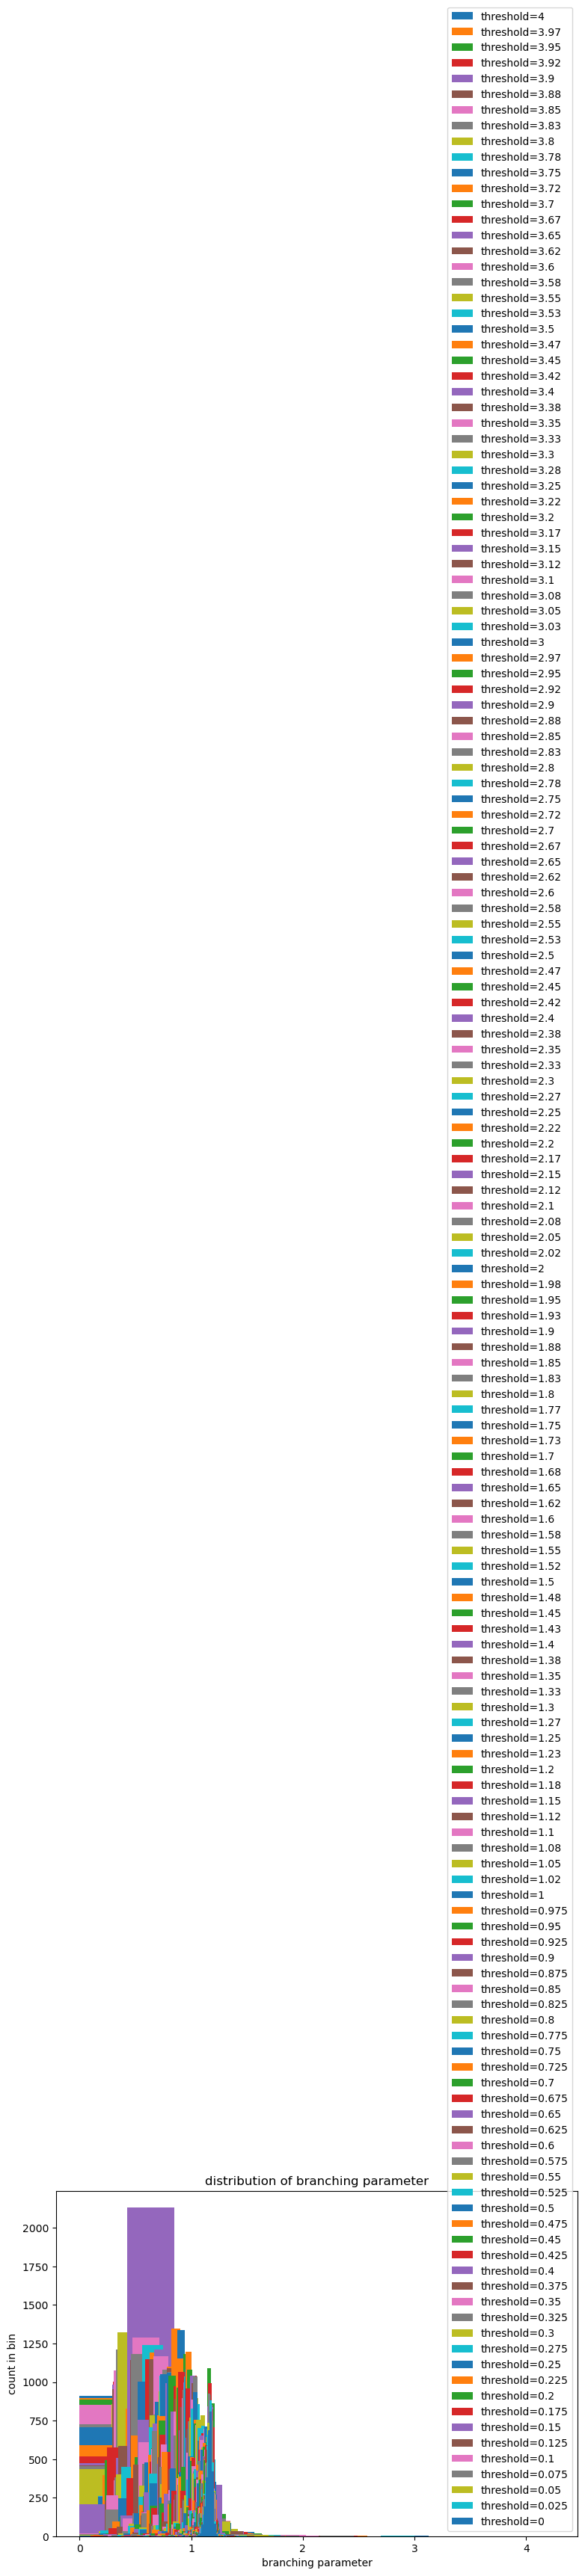

In [139]:
# make_histogram(name='branching parameter', values=branching_parameters)
row_names = [f'threshold={threshold:.3g}' for threshold in thresholds]
make_histograms_for_rows(  name='branching parameter', row_names=row_names[::-1], values=branching_parameters.flip( dims=(0,) )  )

In [20]:
target_threshold = 1.4
dist_from_target_threshold = torch.abs(thresholds-target_threshold)
closest_threshold_index = torch.argmin(dist_from_target_threshold)
closest_threshold = thresholds[closest_threshold_index]
print(f'closest threshold to {target_threshold:.3g} is {closest_threshold:.3g} at index {closest_threshold_index}')

closest threshold to 1.4 is 1.4 at index 56


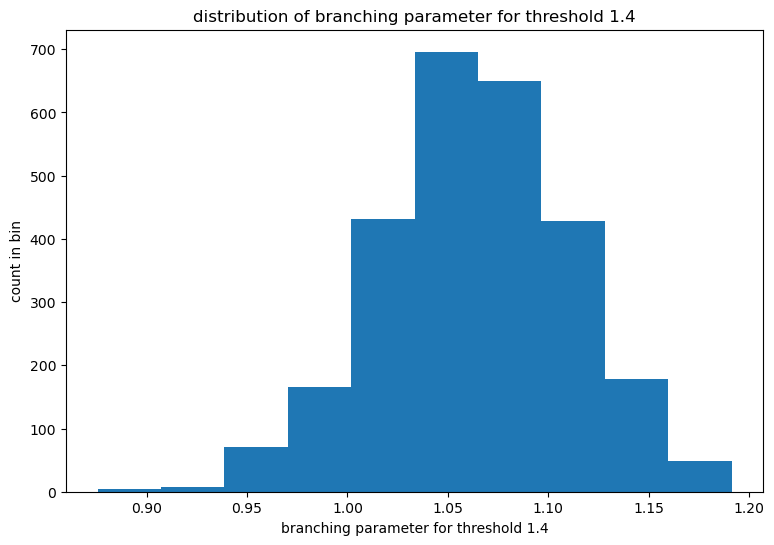

In [21]:
# make_histogram(name='branching parameter', values=branching_parameters)
make_histogram(name=f'branching parameter for threshold {closest_threshold:.3g}', values=branching_parameters[closest_threshold_index,:])

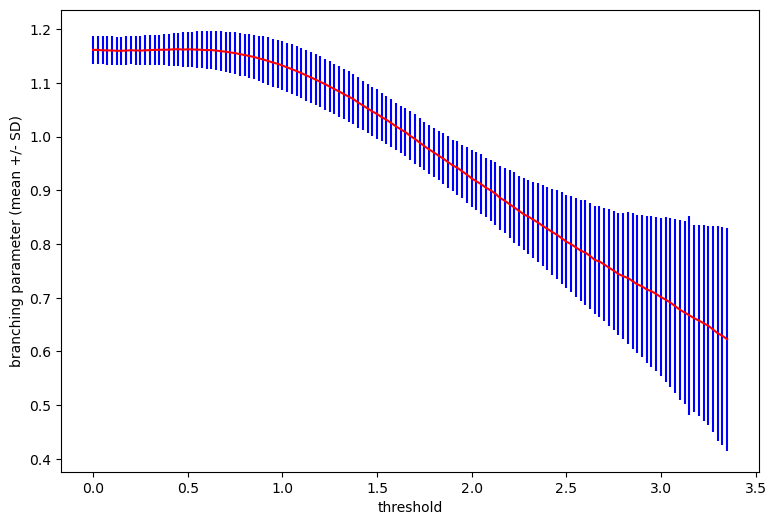

In [22]:
bp_std, bp_mean = torch.std_mean(branching_parameters, dim=-1)
make_errorbar(xname='threshold', xvalues=thresholds, yname='branching parameter (mean +/- SD)', yvalues=bp_mean, yerrs=bp_std)

In [23]:
num_perms = 200
# p_value_branching_parameter_minus_1_all_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10_perms_10.pt
p_value_bp = torch.load( os.path.join(file_dir, f'p_value_branching_parameter_minus_1_{file_suffix}_perms_{num_perms}.pt') )/num_perms
print( 'p_value_bp size', p_value_bp.size() )
print( p_value_bp.dtype )

p_value_bp size torch.Size([161, 2680])
torch.float32


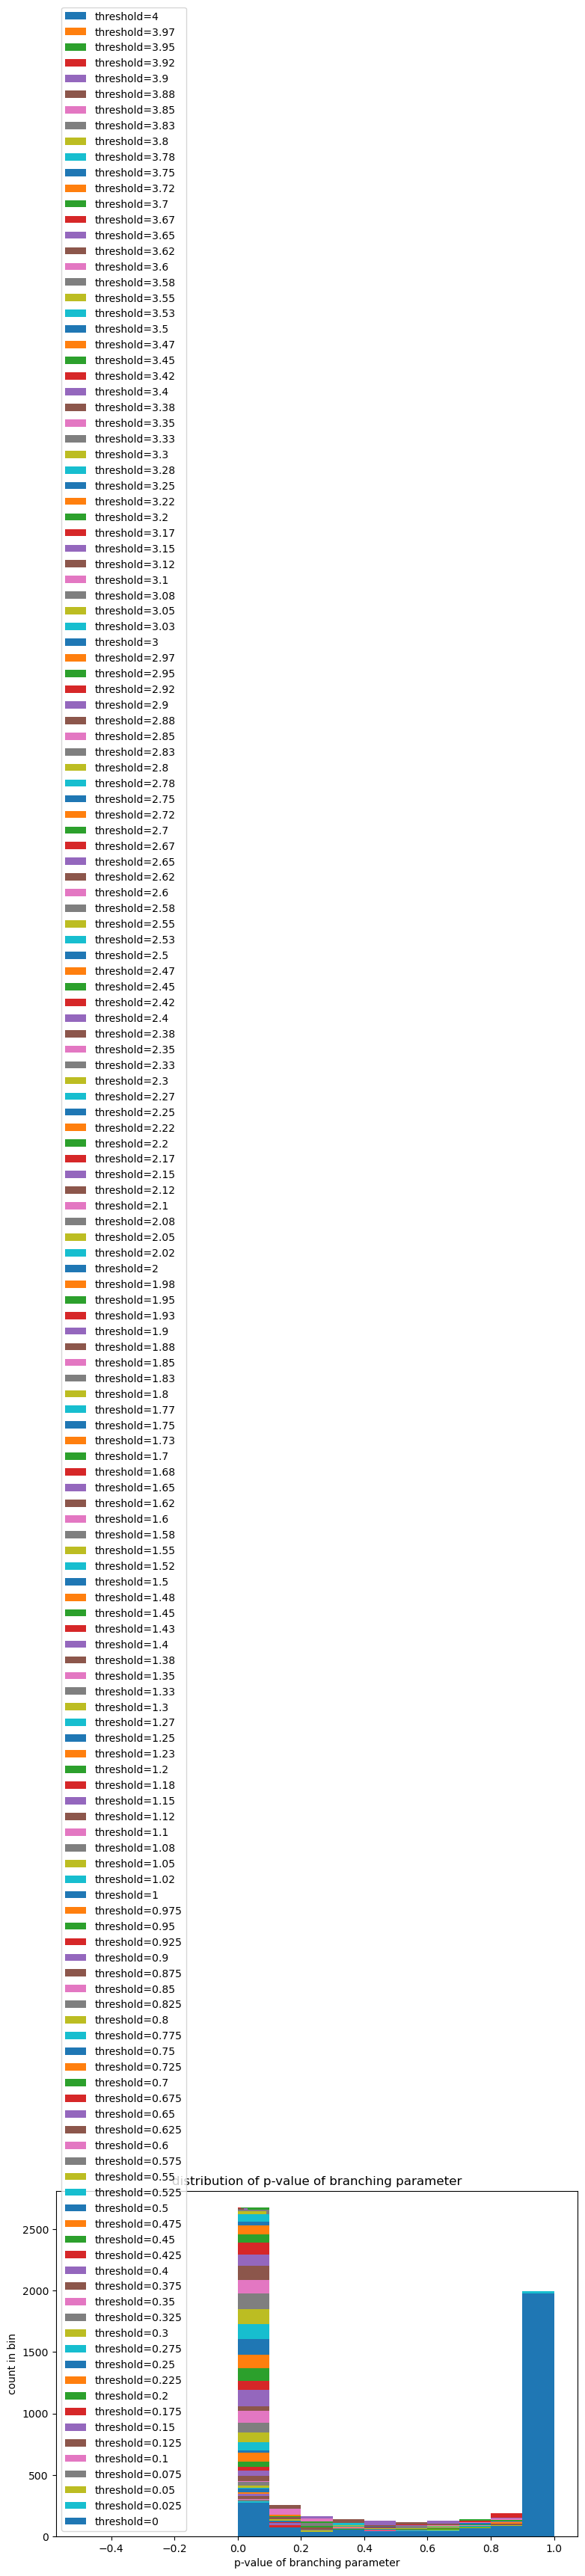

In [144]:
# make_histogram(name='branching parameter', values=branching_parameters)
row_names = [f'threshold={threshold:.3g}' for threshold in thresholds]
make_histograms_for_rows(  name='p-value of branching parameter', row_names=row_names[::-1], values=p_value_bp.flip( dims=(0,) )  )

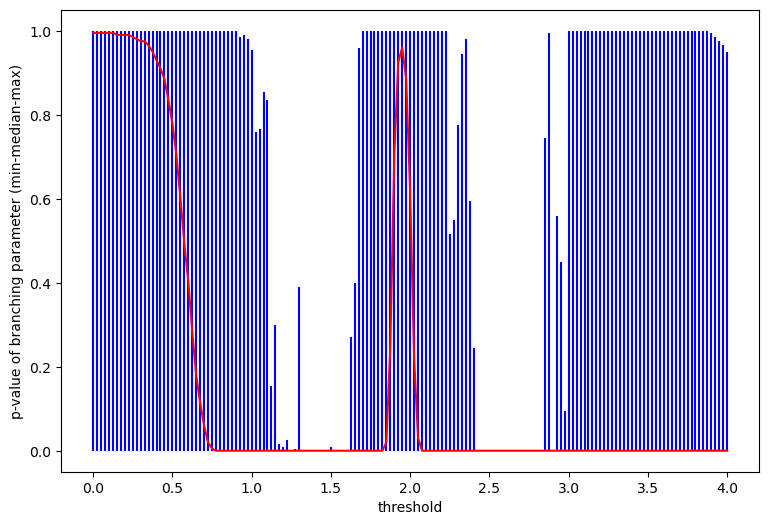

In [24]:
pbp_median = p_value_bp.median(dim=-1).values
pbp_min = p_value_bp.min(dim=-1).values
pbp_max = p_value_bp.max(dim=-1).values
pbp_min_med_max = torch.stack( (pbp_min, pbp_median, pbp_max), dim=-1 )
make_errorbar_two_sides(xname='threshold', xvalues=thresholds, yname='p-value of branching parameter (min-median-max)', yvalues=pbp_min_med_max)

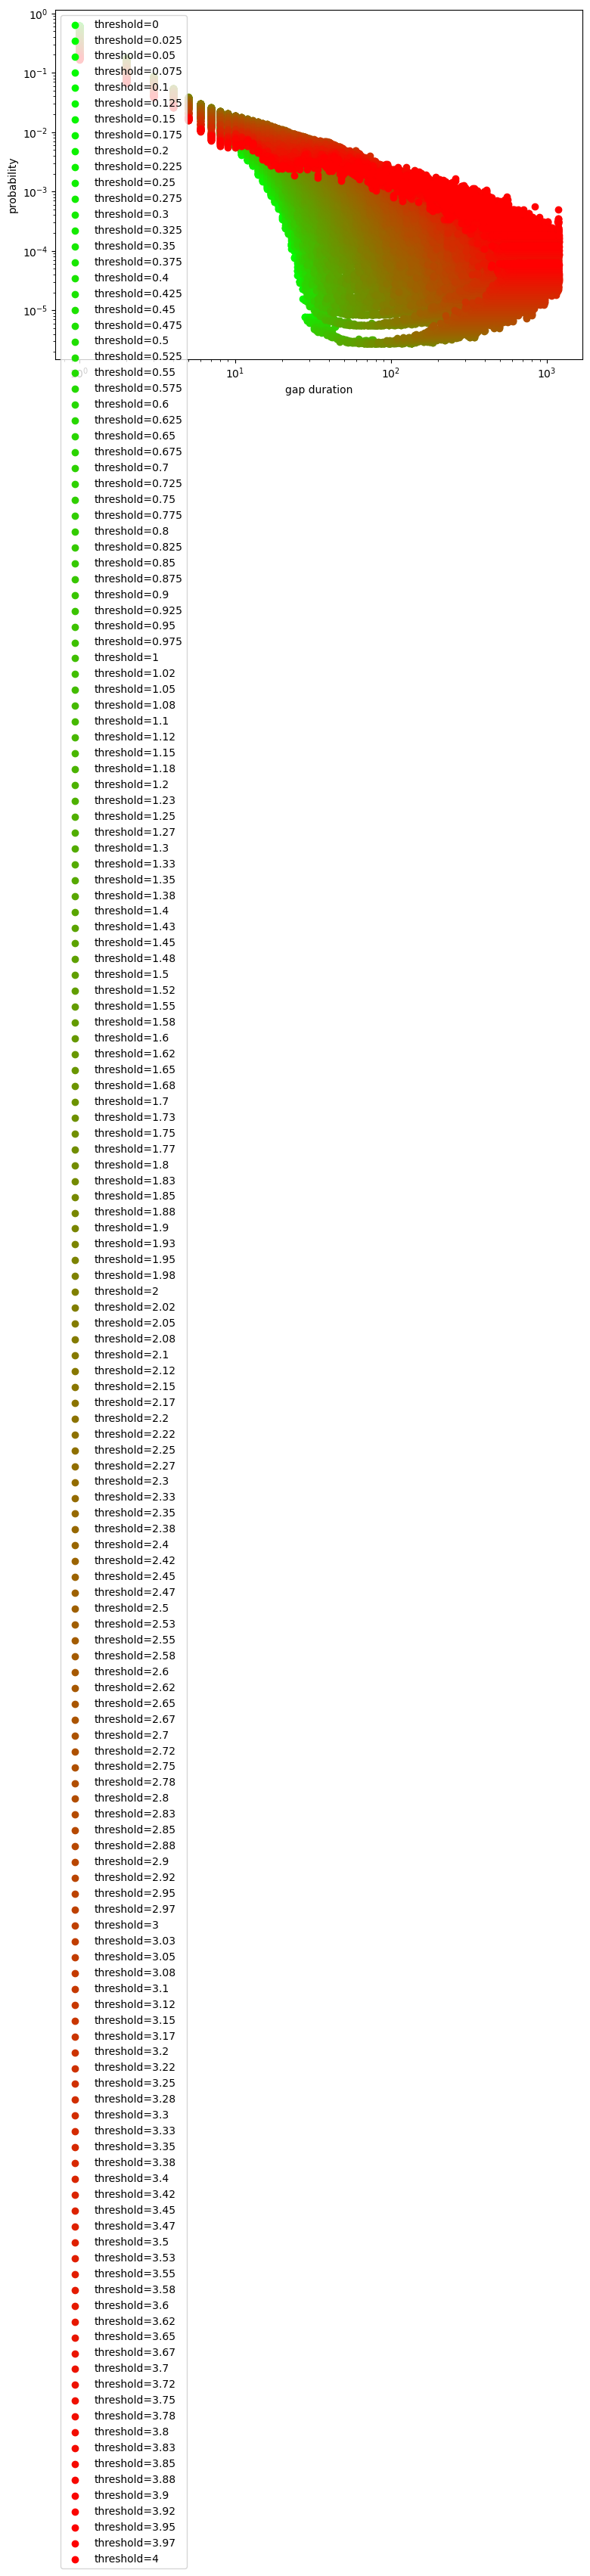

In [31]:
plot_for_threshold(x=gap_durations, x_name='gap duration', y_for_threshold=gap_duration_counts)

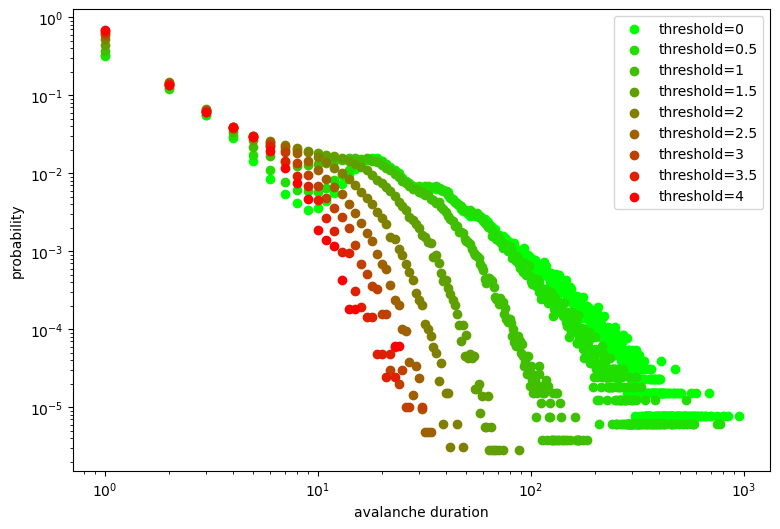

In [58]:
plot_for_threshold(x=durations, x_name='avalanche duration', y_for_threshold=duration_counts)

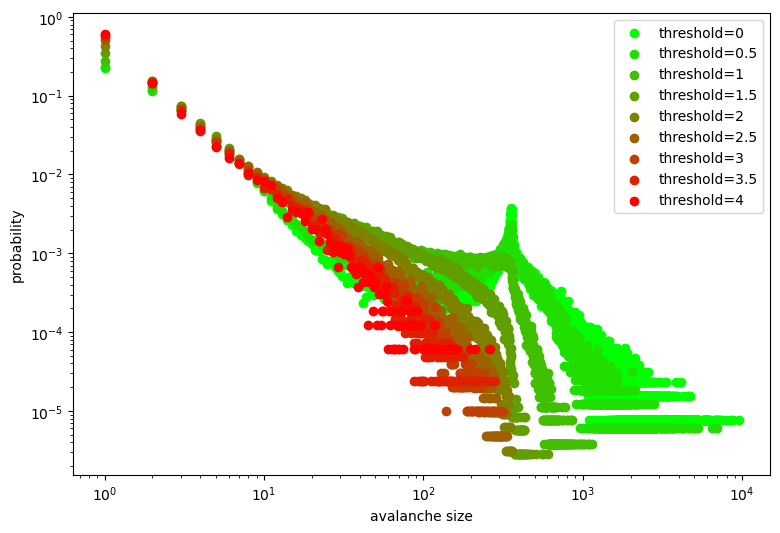

In [59]:
plot_for_threshold(x=sizes, x_name='avalanche size', y_for_threshold=size_counts)

In [25]:
# best_log_likelihood_gap_duration_all_perm_10_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
count_names=['gap_duration', 'avalanche_duration', 'avalanche_size']
num_counts = len(count_names)
stat_names = ['best_exponent', 'best_log_likelihood', 'approx_exponent', 'approx_log_likelihood', 'ks_distance', 'kappa']
num_stats = len(stat_names)
num_thresholds = thresholds.numel()
num_x_min = max_x_min
distribution_stats = torch.zeros( size=(num_counts, num_stats, num_thresholds, num_x_min), dtype=float_type, device=device )
for count_index in range(num_counts):
    count_name = count_names[count_index]
    for stat_index in range(num_stats):
        stat_name = stat_names[stat_index]
        stat_file = os.path.join(file_dir, f'{stat_name}_{count_name}_{file_suffix}.pt')
        distribution_stats[count_index,stat_index,:,:] = torch.load(stat_file)
        print(f'loaded {stat_file}')
print( 'distribution_stats size', distribution_stats.size() )

loaded E:\Ising_model_results_daai\best_exponent_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\best_log_likelihood_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\approx_exponent_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\approx_log_likelihood_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\ks_distance_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\kappa_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\best_exponent_avalanche_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\best_log_likelihood_avalanche_duration_all_thresholds_161_from_0_to_4_maxxmin_

In [26]:
# best_log_likelihood_gap_duration_all_perm_10_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
count_names=['gap_duration', 'avalanche_duration', 'avalanche_size']
num_counts = len(count_names)
stat_names = ['best_exponent', 'best_log_likelihood', 'approx_exponent', 'approx_log_likelihood', 'ks_distance', 'kappa']
num_stats = len(stat_names)
num_thresholds = thresholds.numel()
num_x_min = max_x_min
distribution_stats_perm = torch.zeros( size=(num_counts, num_stats, num_thresholds, num_x_min), dtype=float_type, device=device )
for count_index in range(num_counts):
    count_name = count_names[count_index]
    for stat_index in range(num_stats):
        stat_name = stat_names[stat_index]
        perm_stat_file = os.path.join(file_dir, f'{stat_name}_{count_name}_{perm_file_suffix}.pt')
        distribution_stats_perm[count_index,stat_index,:,:] = torch.load(perm_stat_file)
        print(f'loaded {perm_stat_file}')
print( 'distribution_stats size', distribution_stats_perm.size() )

loaded E:\Ising_model_results_daai\best_exponent_gap_duration_all_perm_1_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\best_log_likelihood_gap_duration_all_perm_1_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\approx_exponent_gap_duration_all_perm_1_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\approx_log_likelihood_gap_duration_all_perm_1_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\ks_distance_gap_duration_all_perm_1_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\kappa_gap_duration_all_perm_1_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\best_exponent_avalanche_duration_all_perm_1_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10.pt
loaded E:\Ising_model_results_daai\best_log_likelihood_avalanche

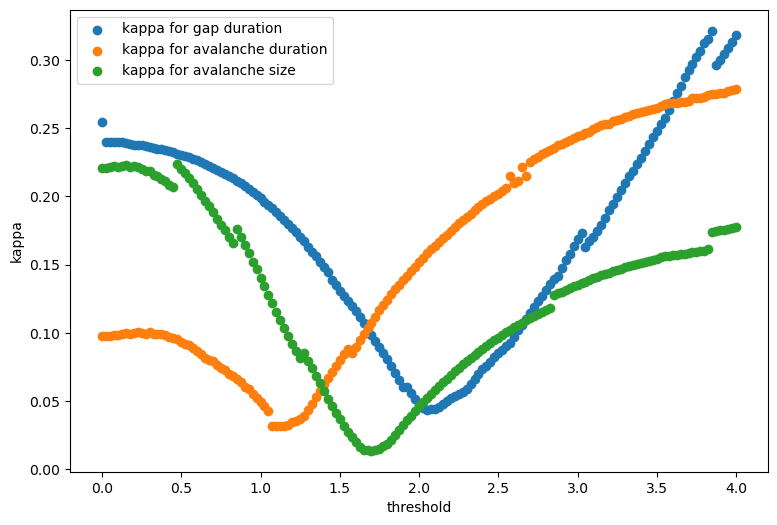

In [27]:
count_names=['gap duration', 'avalanche duration', 'avalanche size']
stat_names = ['best exponent', 'best log likelihood', 'closed-form exponent', 'closed-form log likelihood', 'KS-distance', 'kappa']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
for count_index in [0,1,2]:
    for stat_index in [5]:
        for x_min_index in [0]:
            # label = f'{stat_names[stat_index]} for {count_names[count_index]} with x_min={x_min_index+1}'
            label = f'{stat_names[stat_index]} for {count_names[count_index]}'
            make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=distribution_stats[count_index,stat_index,:,x_min_index], label=label)
axs.legend()
axs.set_xlabel('threshold')
axs.set_ylabel('kappa')
plt.show()

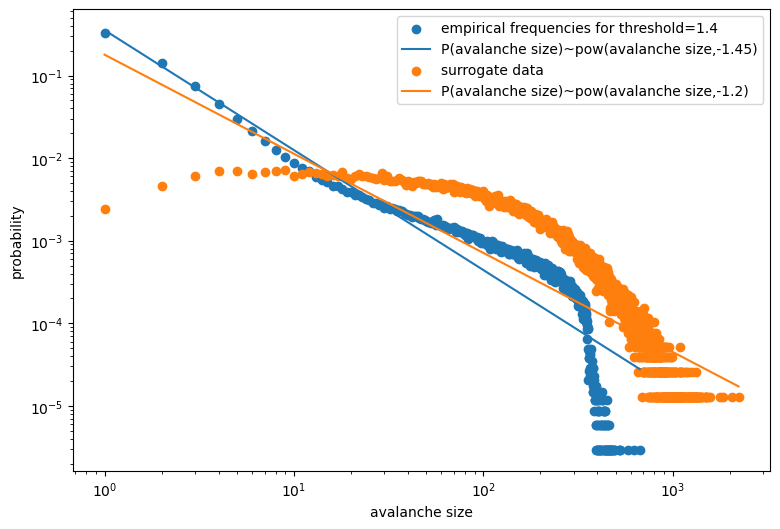

In [28]:
# count_index = 0# gap duration
# count_index = 1# avalanche duration
count_index = 2# avalanche size
stat_index = 0# best exponent
x_min_index = 0# 1
x_min = x_min_index+1

count_names=['gap duration', 'avalanche duration', 'avalanche size']
count_tensors = [gap_duration_counts, duration_counts, size_counts]
value_tensors = [gap_durations, durations, sizes]

count_name = count_names[count_index]
values = value_tensors[count_index]

counts_for_threshold = (count_tensors[count_index])[closest_threshold_index,:]
probs_for_threshold = counts_for_threshold/torch.sum(counts_for_threshold)

has_prob = probs_for_threshold > 0
real_values = values[has_prob]
probs_for_threshold = probs_for_threshold[has_prob]

exponent_for_threshold = distribution_stats[count_index,stat_index,closest_threshold_index,x_min_index]
power_law_probs = torch.pow(real_values, -exponent_for_threshold)/torch.special.zeta(exponent_for_threshold, x_min)

perm_count_tensors = [gap_duration_counts_perm, duration_counts_perm, size_counts_perm]
perm_value_tensors = [gap_durations_perm, durations_perm, sizes_perm]

perm_values = perm_value_tensors[count_index]

perm_counts_for_threshold = (perm_count_tensors[count_index])[closest_threshold_index,:]
perm_probs_for_threshold = perm_counts_for_threshold/torch.sum(perm_counts_for_threshold)

perm_has_prob = perm_probs_for_threshold > 0
perm_values = perm_values[perm_has_prob]
perm_probs_for_threshold = perm_probs_for_threshold[perm_has_prob]

perm_exponent_for_threshold = distribution_stats_perm[count_index,stat_index,closest_threshold_index,x_min_index]
perm_power_law_probs = torch.pow(perm_values, -perm_exponent_for_threshold)/torch.special.zeta(perm_exponent_for_threshold, x_min)

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )

axs.scatter( depytorch(real_values), depytorch(probs_for_threshold), label=f'empirical frequencies for threshold={closest_threshold:.3g}' )
axs.plot( depytorch(real_values), depytorch(power_law_probs), label=f'P({count_name})~pow({count_name},-{exponent_for_threshold:.3g})' )

axs.scatter( depytorch(perm_values), depytorch(perm_probs_for_threshold), label=f'surrogate data' )
axs.plot( depytorch(perm_values), depytorch(perm_power_law_probs), label=f'P({count_name})~pow({count_name},-{perm_exponent_for_threshold:.3g})' )

# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel(count_name)
axs.set_ylabel('probability')
# axs.set_title(f'{xname} vs {yname}')
axs.legend()

In [29]:
for count_index in range(3):
    for stat_index in range(6):
        for x_min_index in [0]:
            selected_values = distribution_stats[count_index,stat_index,:,x_min_index]
            print(f'{stat_names[stat_index]} for {count_names[count_index]} has min {selected_values.min():.3g} at threshold {thresholds[selected_values.argmin()]:.3g}')

best exponent for gap duration has min 1.25 at threshold 4
best log likelihood for gap duration has min -8.62e+05 at threshold 1.95
closed-form exponent for gap duration has min 1.24 at threshold 4
closed-form log likelihood for gap duration has min -8.65e+05 at threshold 1.95
KS-distance for gap duration has min 0.0382 at threshold 0.45
kappa for gap duration has min 0.0436 at threshold 2.05
best exponent for avalanche duration has min 1.43 at threshold 0.15
best log likelihood for avalanche duration has min -8.55e+05 at threshold 1.35
closed-form exponent for avalanche duration has min 1.4 at threshold 0.15
closed-form log likelihood for avalanche duration has min -8.58e+05 at threshold 1.35
KS-distance for avalanche duration has min 0.0219 at threshold 3.72
kappa for avalanche duration has min 0.0314 at threshold 1.15
best exponent for avalanche size has min 1.28 at threshold 0.15
best log likelihood for avalanche size has min -1.21e+06 at threshold 1.33
closed-form exponent for ava

In [30]:
for count_index in range(3):
    for stat_index in range(6):
        for x_min_index in [0]:
            selected_values = distribution_stats[count_index,stat_index,:,x_min_index]
            print(f'{stat_names[stat_index]} for {count_names[count_index]} has max {selected_values.max():.3g} at threshold {thresholds[selected_values.argmax()]:.3g}')

best exponent for gap duration has max 2.16 at threshold 0.05
best log likelihood for gap duration has max -9.54e+04 at threshold 4
closed-form exponent for gap duration has max 1.88 at threshold 0.05
closed-form log likelihood for gap duration has max -9.54e+04 at threshold 4
KS-distance for gap duration has max 0.204 at threshold 4
kappa for gap duration has max 0.322 at threshold 3.85
best exponent for avalanche duration has max 2.33 at threshold 4
best log likelihood for avalanche duration has max -1.93e+04 at threshold 4
closed-form exponent for avalanche duration has max 1.95 at threshold 4
closed-form log likelihood for avalanche duration has max -2e+04 at threshold 4
KS-distance for avalanche duration has max 0.156 at threshold 0.025
kappa for avalanche duration has max 0.279 at threshold 4
best exponent for avalanche size has max 1.97 at threshold 4
best log likelihood for avalanche size has max -2.76e+04 at threshold 4
closed-form exponent for avalanche size has max 1.77 at t

In [31]:
target = 1.5
for count_index in range(3):
    for stat_index in [0, 2]:
        for x_min_index in [0]:
            selected_values = torch.abs(distribution_stats[count_index,stat_index,:,x_min_index] - 1.5)
            print(f'{stat_names[stat_index]} for {count_names[count_index]} has least distance {selected_values.min():.3g} from target {target:.3g} at threshold {thresholds[selected_values.argmin()]:.3g}')

best exponent for gap duration has least distance 0.000819 from target 1.5 at threshold 2.4
closed-form exponent for gap duration has least distance 0.00198 from target 1.5 at threshold 2.2
best exponent for avalanche duration has least distance 0.00142 from target 1.5 at threshold 0.8
closed-form exponent for avalanche duration has least distance 0.000427 from target 1.5 at threshold 1.05
best exponent for avalanche size has least distance 0.00236 from target 1.5 at threshold 1.6
closed-form exponent for avalanche size has least distance 0.00168 from target 1.5 at threshold 1.8


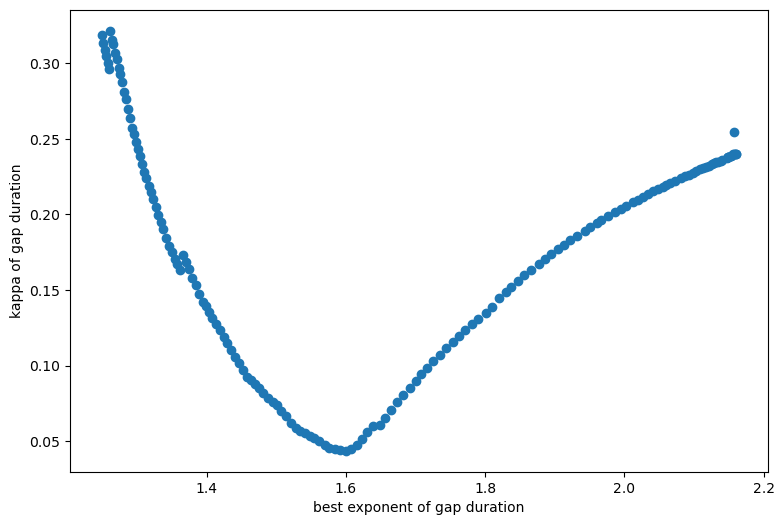

In [32]:
count_names=['gap duration', 'avalanche duration', 'avalanche size']
stat_names = ['best exponent', 'best log likelihood', 'closed-form exponent', 'closed-form log likelihood', 'KS-distance', 'kappa']
count_index = 0
x_min_index = 0
x_stat_index = 0
y_stat_index = 5
make_scatter(xname=f'{stat_names[x_stat_index]} of {count_names[count_index]}', xvalues=distribution_stats[count_index,x_stat_index,:,x_min_index], yname=f'{stat_names[y_stat_index]} of {count_names[count_index]}', yvalues=distribution_stats[count_index,y_stat_index,:,x_min_index])

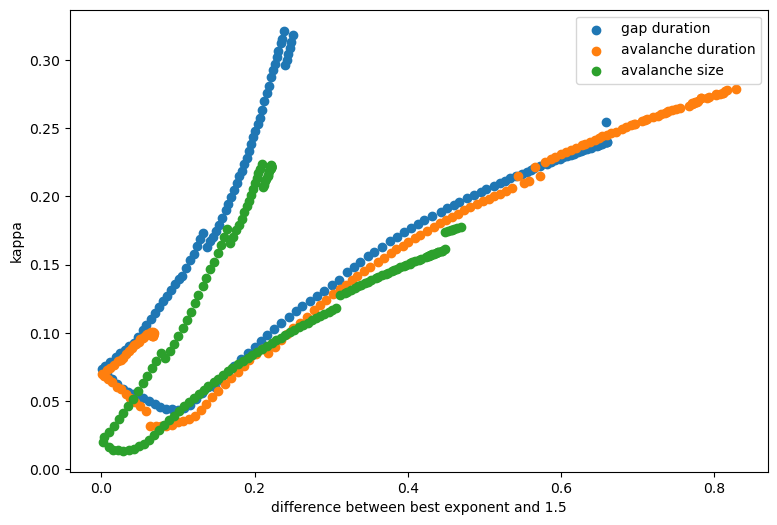

In [33]:
target = 1.5
count_names=['gap duration', 'avalanche duration', 'avalanche size']
stat_names = ['best exponent', 'best log likelihood', 'closed-form exponent', 'closed-form log likelihood', 'KS-distance', 'kappa']
x_min_index = 0
x_stat_index = 0
y_stat_index = 5
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
for count_index in range( len(count_names) ):
    x_dist = torch.abs(distribution_stats[count_index,x_stat_index,:,x_min_index]-target)
    label = f'{count_names[count_index]}'
    make_scatter_with_handle(axs=axs, xvalues=x_dist, yvalues=distribution_stats[count_index,y_stat_index,:,x_min_index], label=label)
axs.legend()
axs.set_xlabel(f'difference between {stat_names[x_stat_index]} and {target:.3g}')
axs.set_ylabel(stat_names[y_stat_index])
plt.show()

In [34]:
# p_value_best_log_likelihood_gap_duration_all_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10_perms_10.pt
count_names=['gap_duration', 'avalanche_duration', 'avalanche_size']
num_counts = len(count_names)
stat_names = ['best_log_likelihood', 'approx_log_likelihood', 'ks_distance', 'kappa']
num_stats = len(stat_names)
num_thresholds = thresholds.numel()
num_x_min = max_x_min
distribution_p_values = torch.zeros( size=(num_counts, num_stats, num_thresholds, num_x_min), dtype=float_type, device=device )
for count_index in range(num_counts):
    count_name = count_names[count_index]
    for stat_index in range(num_stats):
        stat_name = stat_names[stat_index]
        p_file = os.path.join(file_dir, f'p_value_{stat_name}_{count_name}_{file_suffix}_perms_{num_perms}.pt')
        distribution_p_values[count_index,stat_index,:,:] = torch.load(p_file)
        print(f'loaded {p_file}')
distribution_p_values /= num_perms
print( 'distribution_p_values size', distribution_p_values.size() )

loaded E:\Ising_model_results_daai\p_value_best_log_likelihood_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10_perms_200.pt
loaded E:\Ising_model_results_daai\p_value_approx_log_likelihood_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10_perms_200.pt
loaded E:\Ising_model_results_daai\p_value_ks_distance_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10_perms_200.pt
loaded E:\Ising_model_results_daai\p_value_kappa_gap_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10_perms_200.pt
loaded E:\Ising_model_results_daai\p_value_best_log_likelihood_avalanche_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10_perms_200.pt
loaded E:\Ising_model_results_daai\p_value_approx_log_likelihood_avalanche_duration_all_thresholds_161_from_0_to_4_maxxmin_2_passes_10_tries_10_perms_200.pt
loaded E:\Ising_model_results_daai\p_value_ks_distance_avalanche_duration_all_thresholds_161_from_0_to_4_maxxmin

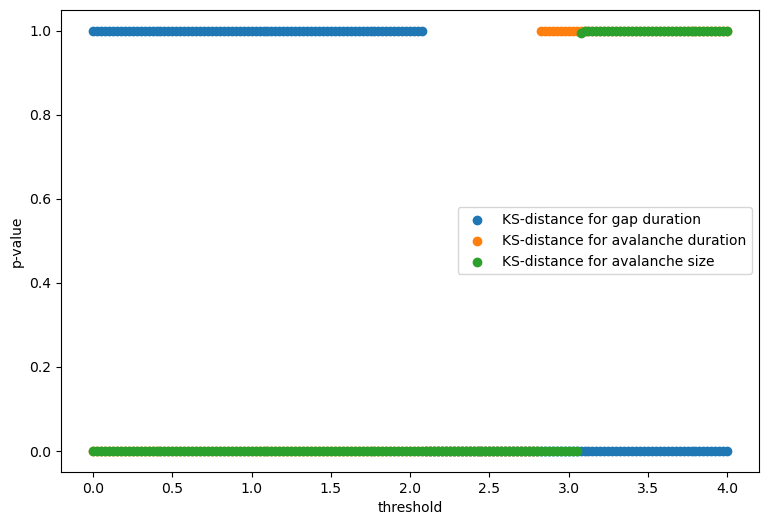

In [35]:
count_names=['gap duration', 'avalanche duration', 'avalanche size']
stat_names = ['best log likelihood', 'closed-form log likelihood', 'KS-distance', 'kappa']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
for count_index in [0,1,2]:
    for stat_index in [2]:
        for x_min_index in [0]:
            # label = f'{stat_names[stat_index]} for {count_names[count_index]} with x_min={x_min_index+1}'
            label = f'{stat_names[stat_index]} for {count_names[count_index]}'
            make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=distribution_p_values[count_index,stat_index,:,x_min_index], label=label)
axs.legend()
axs.set_xlabel('threshold')
axs.set_ylabel('p-value')
plt.show()

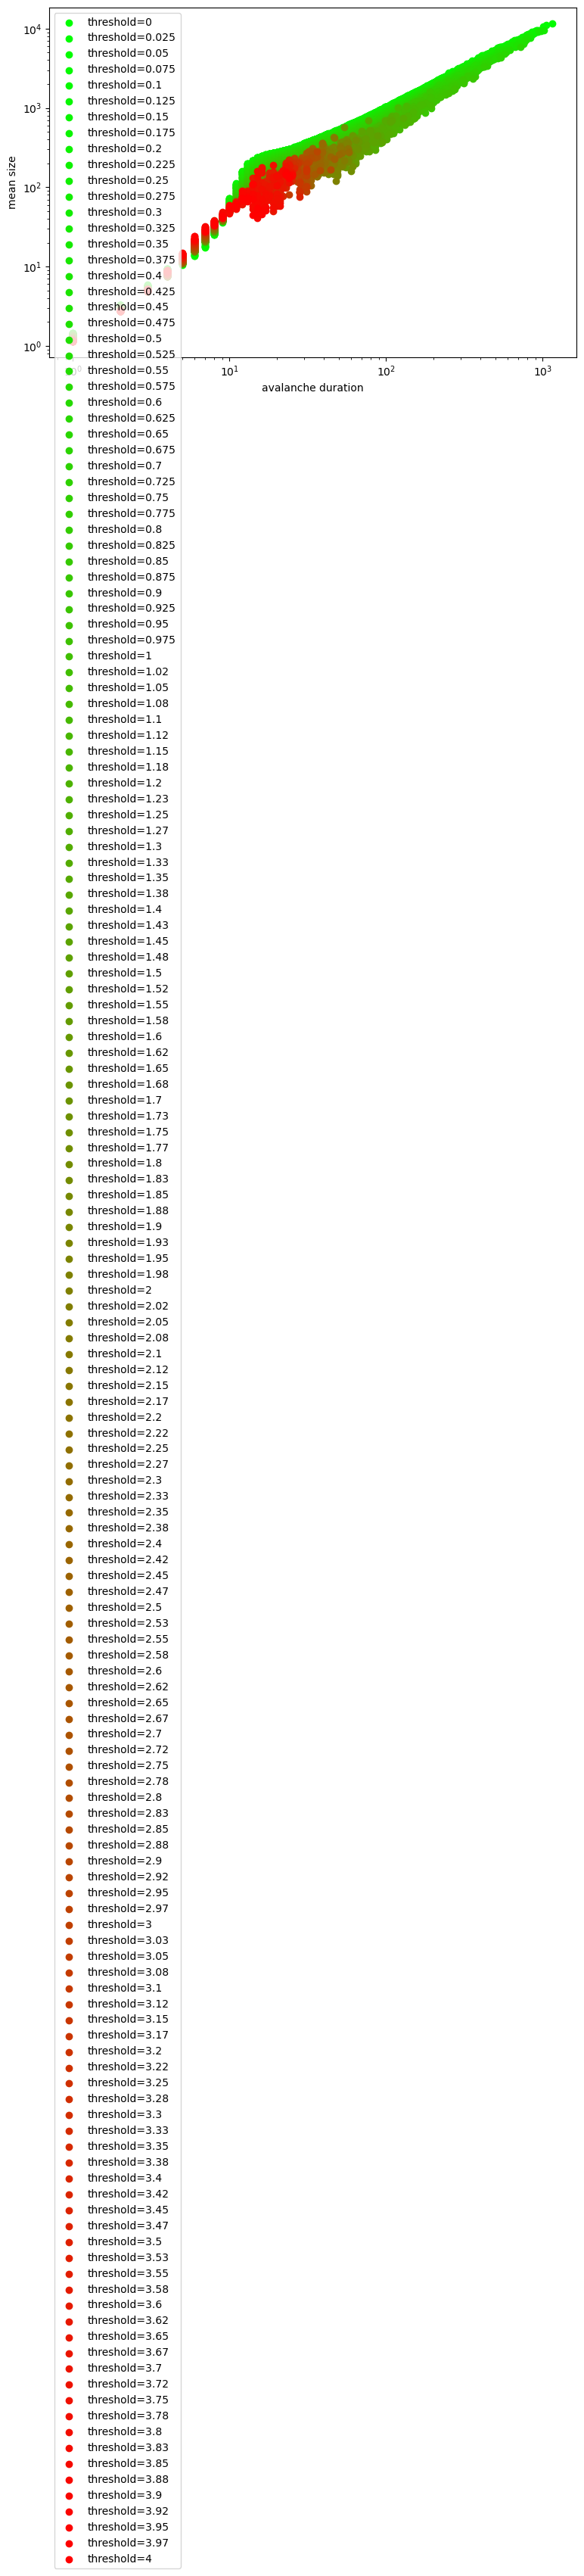

In [43]:
plot_for_threshold(x=durations_for_mean_size, x_name='avalanche duration', y_for_threshold=mean_size_for_duration, y_name='mean size', convert_to_prob=False)

In [36]:
# r_squared_mean_size_for_duration_all_perm_10_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
# exponent_mean_size_for_duration_all_perm_10_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
count_name = 'mean_size_for_duration'
stat_name = 'r_squared'
r_squared = torch.load( os.path.join(file_dir, f'{stat_name}_{count_name}_{file_suffix}.pt') )
print( 'r_squared size', r_squared.size() )
stat_name = 'exponent'
size_vs_duration_exponent = torch.load( os.path.join(file_dir, f'{stat_name}_{count_name}_{file_suffix}.pt') )
print( 'size vs duration exponent size', size_vs_duration_exponent.size() )
stat_name = 'scale_factor'
size_vs_duration_scale_factor = torch.load( os.path.join(file_dir, f'{stat_name}_{count_name}_{file_suffix}.pt') )
print( 'size vs duration scale_factor size', size_vs_duration_scale_factor.size() )

r_squared size torch.Size([161, 2])
size vs duration exponent size torch.Size([161, 2])
size vs duration scale_factor size torch.Size([161, 2])


In [37]:
# r_squared_mean_size_for_duration_all_perm_10_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
# exponent_mean_size_for_duration_all_perm_10_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
count_name = 'mean_size_for_duration'
stat_name = 'r_squared'
r_squared_perm = torch.load( os.path.join(file_dir, f'{stat_name}_{count_name}_{perm_file_suffix}.pt') )
print( 'r_squared_perm size', r_squared_perm.size() )
stat_name = 'exponent'
size_vs_duration_exponent_perm = torch.load( os.path.join(file_dir, f'{stat_name}_{count_name}_{perm_file_suffix}.pt') )
print( 'size vs duration exponent perm size', size_vs_duration_exponent_perm.size() )
stat_name = 'scale_factor'
size_vs_duration_scale_factor_perm = torch.load( os.path.join(file_dir, f'{stat_name}_{count_name}_{perm_file_suffix}.pt') )
print( 'size vs duration scale factor perm size', size_vs_duration_scale_factor_perm.size() )

r_squared_perm size torch.Size([161, 2])
size vs duration exponent perm size torch.Size([161, 2])
size vs duration scale factor perm size torch.Size([161, 2])


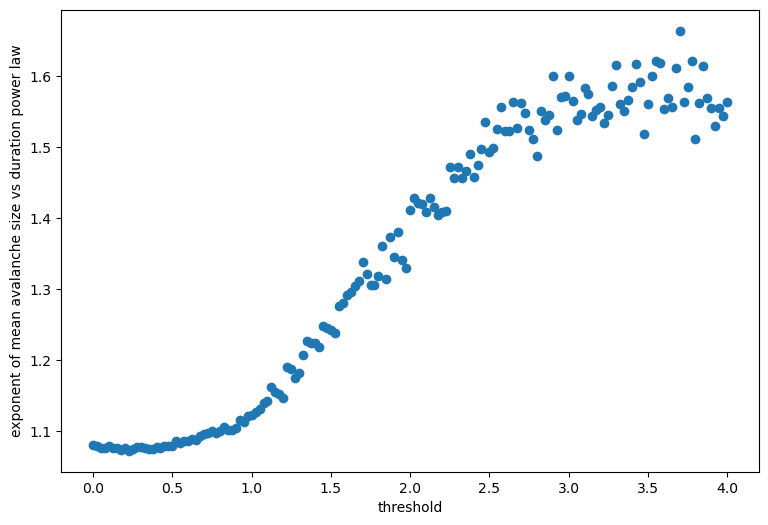

In [38]:
x_min_index = 0
make_scatter(xname='threshold', xvalues=thresholds, yname='exponent of mean avalanche size vs duration power law', yvalues=size_vs_duration_exponent[:,x_min_index])

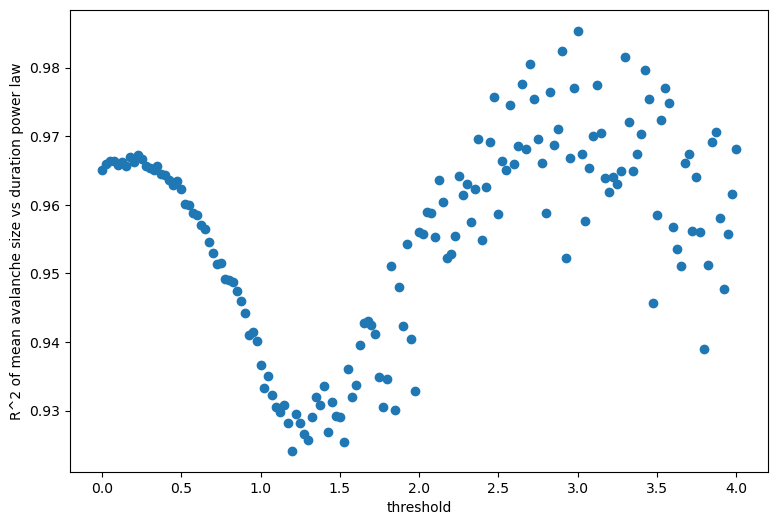

In [39]:
x_min_index = 0
make_scatter(xname='threshold', xvalues=thresholds, yname='R^2 of mean avalanche size vs duration power law', yvalues=r_squared[:,x_min_index])

In [40]:
print( f'[{r_squared[:,x_min_index].min():.3g}, {r_squared[:,x_min_index].max():.3g}]' )

[0.924, 0.985]


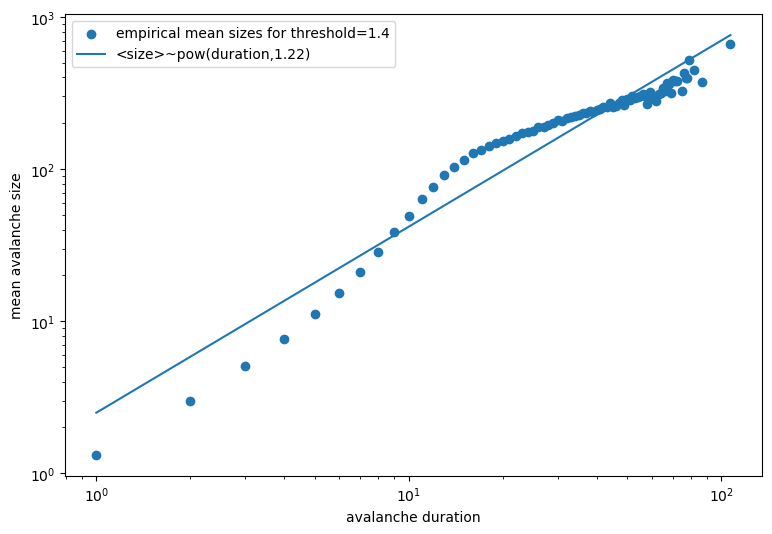

In [41]:
# count_index = 0# gap duration
count_index = 2# avalanche duration
stat_index = 0# best exponent
x_min_index = 0# 1
x_min = x_min_index+1

count_names=['gap duration', 'avalanche duration', 'avalanche size']
count_tensors = [gap_duration_counts, duration_counts, size_counts]
value_tensors = [gap_durations, durations, sizes]

x_count_name = 'avalanche duration'
y_count_name = 'mean avalanche size'
values = durations_for_mean_size
mean_size_for_threshold = mean_size_for_duration[closest_threshold_index,:]

has_size = mean_size_for_threshold > 0
values = values[has_size]
mean_size_for_threshold = mean_size_for_threshold[has_size]

exponent_for_threshold = size_vs_duration_exponent[closest_threshold_index,x_min_index]
scale_factor_for_threshold = size_vs_duration_scale_factor[closest_threshold_index,x_min_index]
power_law_sizes = torch.exp( scale_factor_for_threshold + exponent_for_threshold * torch.log(values) )

make_scatter_and_line(xname=x_count_name, xvalues=values, yname=y_count_name, scatter_label=f'empirical mean sizes for threshold={closest_threshold:.3g}', y_scatter_values=mean_size_for_threshold, line_label=f'<size>~pow(duration,{exponent_for_threshold:.3g})', y_line_values=power_law_sizes, do_log_log=True)

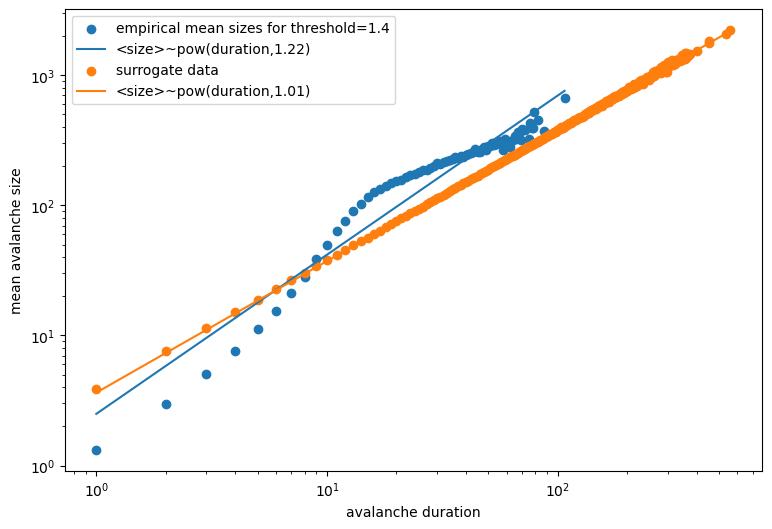

In [42]:
stat_index = 0# best exponent
x_min_index = 0# 1
x_min = x_min_index+1

x_count_name = 'avalanche duration'
y_count_name = 'mean avalanche size'

values = durations_for_mean_size
mean_size_for_threshold = mean_size_for_duration[closest_threshold_index,:]

has_size = mean_size_for_threshold > 0
values = values[has_size]
mean_size_for_threshold = mean_size_for_threshold[has_size]

exponent_for_threshold = size_vs_duration_exponent[closest_threshold_index,x_min_index]
scale_factor_for_threshold = size_vs_duration_scale_factor[closest_threshold_index,x_min_index]
power_law_sizes = torch.exp( scale_factor_for_threshold + exponent_for_threshold * torch.log(values) )

perm_values = durations_for_mean_size_perm
perm_mean_size_for_threshold = mean_size_for_duration_perm[closest_threshold_index,:]

perm_has_size = perm_mean_size_for_threshold > 0
perm_values = perm_values[perm_has_size]
perm_mean_size_for_threshold = perm_mean_size_for_threshold[perm_has_size]

perm_exponent_for_threshold = size_vs_duration_exponent_perm[closest_threshold_index,x_min_index]
perm_scale_factor_for_threshold = size_vs_duration_scale_factor_perm[closest_threshold_index,x_min_index]
perm_power_law_sizes = torch.exp( perm_scale_factor_for_threshold + perm_exponent_for_threshold * torch.log(perm_values) )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )

axs.scatter( depytorch(values), depytorch(mean_size_for_threshold), label=f'empirical mean sizes for threshold={closest_threshold:.3g}' )
axs.plot( depytorch(values), depytorch(power_law_sizes), label=f'<size>~pow(duration,{exponent_for_threshold:.3g})' )

axs.scatter( depytorch(perm_values), depytorch(perm_mean_size_for_threshold), label=f'surrogate data' )
axs.plot( depytorch(perm_values), depytorch(perm_power_law_sizes), label=f'<size>~pow(duration,{perm_exponent_for_threshold:.3g})' )

# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel('avalanche duration')
axs.set_ylabel('mean avalanche size')
# axs.set_title(f'{xname} vs {yname}')
axs.legend()

In [43]:
x_min_index = 0
stat_index = 0
print( f'size vs duration exponent: {size_vs_duration_exponent[closest_threshold_index,x_min_index]:.3g} vs (1 - duration exponent)/(1 - size exponent): {(1-distribution_stats[1,stat_index,closest_threshold_index,x_min_index])/(1-distribution_stats[2,stat_index,closest_threshold_index,x_min_index])}' )

size vs duration exponent: 1.22 vs (1 - duration exponent)/(1 - size exponent): 1.4598679542541504


In [44]:
x_min_index = 0
stat_index = 2
stat_names = ['best log likelihood', 'closed-form log likelihood', 'KS-distance', 'kappa']
for count_index in range( len(count_names) ):
    print(f'p-value for {stat_names[stat_index]} of {count_names[count_index]} at threshold {closest_threshold:.3g} = {distribution_p_values[count_index,stat_index,closest_threshold_index,x_min_index]:.3g}')

p-value for KS-distance of gap duration at threshold 1.4 = 1
p-value for KS-distance of avalanche duration at threshold 1.4 = 0
p-value for KS-distance of avalanche size at threshold 1.4 = 0


In [45]:
# diff_from_critical_point_all_perm_10_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10.pt
# p_value_diff_from_critical_point_all_thresholds_9_from_0_to_4_maxxmin_10_passes_10_tries_10_perms_10.pt
stat_name = 'diff_from_critical_point'
diff_from_crit = torch.load( os.path.join(file_dir, f'{stat_name}_{file_suffix}.pt') )
print( 'diff_from_crit size', diff_from_crit.size() )
dfc_p_value = torch.load( os.path.join(file_dir, f'p_value_{stat_name}_{file_suffix}_perms_{num_perms}.pt') )/num_perms
print( 'dfc_p_value size', dfc_p_value.size() )

diff_from_crit size torch.Size([161, 2, 2])
dfc_p_value size torch.Size([161, 2, 2])


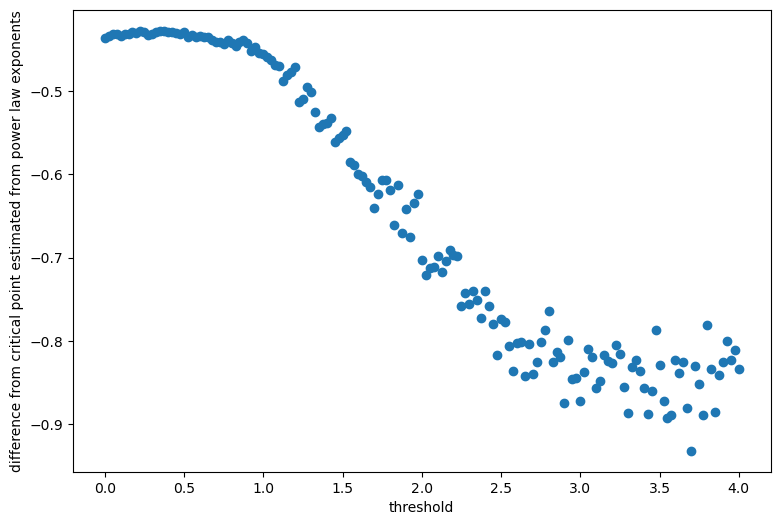

In [46]:
x_min_index = 0
make_scatter(xname='threshold', xvalues=thresholds, yname='difference from critical point estimated from power law exponents', yvalues=diff_from_crit[:,x_min_index,x_min_index])

In [47]:
abs_diff_from_crit = torch.abs(diff_from_crit[:,x_min_index,x_min_index])
print(f'minimum absolute distance from criticality {abs_diff_from_crit.min():.3g} occurs at threshold {thresholds[abs_diff_from_crit.argmin()]:.3g}')

minimum absolute distance from criticality 0.428 occurs at threshold 0.225


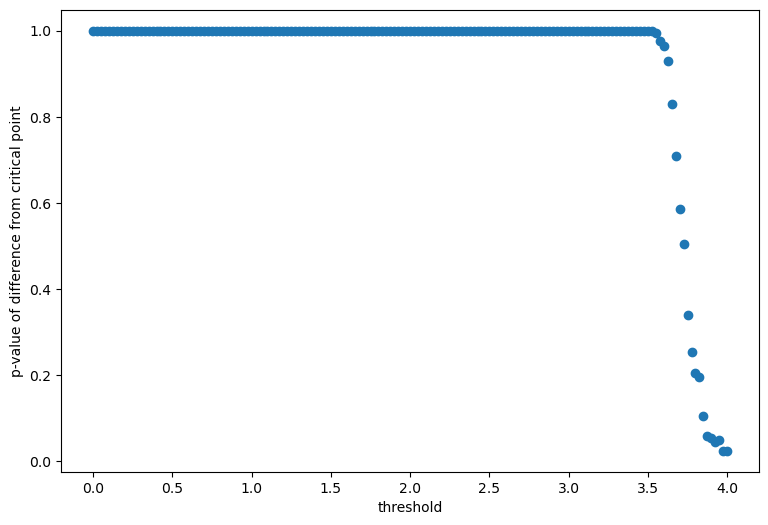

In [48]:
x_min_index = 0
make_scatter(xname='threshold', xvalues=thresholds, yname='p-value of difference from critical point', yvalues=dfc_p_value[:,x_min_index,x_min_index])

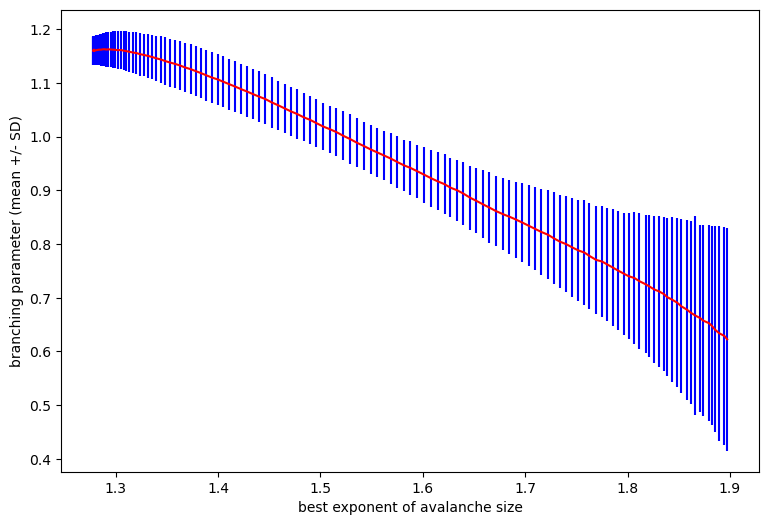

In [49]:
count_names=['gap duration', 'avalanche duration', 'avalanche size']
stat_names = ['best exponent', 'best log likelihood', 'closed-form exponent', 'closed-form log likelihood', 'KS-distance', 'kappa']
count_index = 2
x_stat_index = 0
x_min_index = 0
x_stat = distribution_stats[count_index,x_stat_index,:,x_min_index]
bp_std, bp_mean = torch.std_mean(branching_parameters, dim=-1)
make_errorbar(xname=f'{stat_names[x_stat_index]} of {count_names[count_index]}', xvalues=distribution_stats[count_index,x_stat_index,:,x_min_index], yname='branching parameter (mean +/- SD)', yvalues=bp_mean, yerrs=bp_std)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


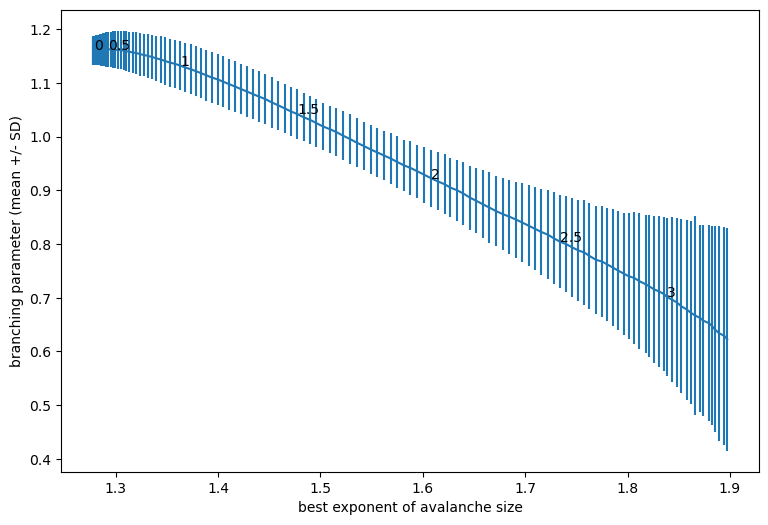

In [50]:
count_names=['gap duration', 'avalanche duration', 'avalanche size']
stat_names = ['best exponent', 'best log likelihood', 'closed-form exponent', 'closed-form log likelihood', 'KS-distance', 'kappa']
count_index = 2
x_stat_index = 0
x_min_index = 0
x_stat = distribution_stats[count_index,x_stat_index,:,x_min_index]
bp_std, bp_mean = torch.std_mean(branching_parameters, dim=-1)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
label = 'branching parameter (mean +/- SD)'
make_errorbar_with_handle(axs=axs, xvalues=x_stat, yvalues=bp_mean, yerrs=bp_std, label=label)
[axs.text(x_stat[thresh_index], bp_mean[thresh_index], f'{thresholds[thresh_index]:.3g}') for thresh_index in range( 0, thresholds.numel(), 20 )]
axs.set_xlabel(f'{stat_names[x_stat_index]} of {count_names[count_index]}')
axs.set_ylabel(label)
plt.show()

In [51]:
count_names=['gap duration', 'avalanche duration', 'avalanche size']
num_counts = len(count_names)
stat_names = ['best exponent', 'best log likelihood', 'closed-form exponent', 'closed-form log likelihood', 'KS-distance', 'kappa']
p_value_names = ['p-value of best log likelihood', 'p-value of closed-form log likelihood', 'p-value of KS-distance', 'p-value of kappa']
mean_branching_parameter = branching_parameters.nanmean(dim=-1)
mbp_diff_from_1 = torch.abs(mean_branching_parameter-1)
x_min_index = 0
stats_for_x_min = distribution_stats[:,:,:,x_min_index]
p_values_for_x_min = distribution_p_values[:,:,:,x_min_index]
svd_exponent_for_x_min = size_vs_duration_exponent[:,x_min_index]
r_squared_for_x_min = r_squared[:,x_min_index]
diff_from_crit_for_x_min = diff_from_crit[:,x_min_index,x_min_index]
dfc_p_value_for_x_min = dfc_p_value[:,x_min_index,x_min_index]
# Search for the thresholds that produce the min, max, and least probable values for the different stats of different counts.
threshold_dim = -1
max_stat, index_of_max_stat = stats_for_x_min.max(dim=threshold_dim)
min_stat, index_of_min_stat = stats_for_x_min.max(dim=threshold_dim)
min_p_value, index_of_min_p_value = p_values_for_x_min.max(dim=threshold_dim)
index_of_mbp_nearest_1 = mbp_diff_from_1.argmin()
target_thresholds = torch.tensor([0.0, 0.5, 1.0, 1.4, 1.5], dtype=float_type, device=device)
min_dist_from_target, min_dist_from_target_index = torch.min( torch.abs(target_thresholds[:,None] - thresholds[None,:]), dim=1 )
selected_threshold_indices = torch.unique(   torch.cat(  ( min_dist_from_target_index, index_of_max_stat.flatten(), index_of_min_stat.flatten(), index_of_min_p_value.flatten(), index_of_mbp_nearest_1.unsqueeze(dim=0) ), dim=0 )   )
stat_and_p_value_names = stat_names + p_value_names
num_stats_and_p_values = len(stat_and_p_value_names)
stats_and_p_values = torch.cat(  (stats_for_x_min, p_values_for_x_min), dim=1  ).flatten(start_dim=0, end_dim=1).transpose(dim0=0, dim1=1)
all_column_values = torch.cat( (thresholds[:,None], stats_and_p_values, svd_exponent_for_x_min[:,None], r_squared_for_x_min[:,None], diff_from_crit_for_x_min[:,None], dfc_p_value_for_x_min[:,None], mean_branching_parameter[:,None], mbp_diff_from_1[:,None]), dim=1 )
delimiter = ','
top_delimiter = num_stats_and_p_values*delimiter
print( delimiter+top_delimiter.join(count_names)+top_delimiter+'mean size for duration'+3*delimiter )
print( 'threshold'+delimiter+delimiter.join(3*stat_and_p_value_names)+delimiter+'exponent'+delimiter+'R^2'+delimiter+'distance from critical point'+delimiter+'p-value of distance from critical point'+delimiter+'mean branching parameter'+delimiter+'bp diff from 1' )
for threshold_index in selected_threshold_indices:
    print( delimiter.join([ f'{value:.3g}' for value in all_column_values[threshold_index,:] ]) )

,gap duration,,,,,,,,,,avalanche duration,,,,,,,,,,avalanche size,,,,,,,,,,mean size for duration,,,
threshold,best exponent,best log likelihood,closed-form exponent,closed-form log likelihood,KS-distance,kappa,p-value of best log likelihood,p-value of closed-form log likelihood,p-value of KS-distance,p-value of kappa,best exponent,best log likelihood,closed-form exponent,closed-form log likelihood,KS-distance,kappa,p-value of best log likelihood,p-value of closed-form log likelihood,p-value of KS-distance,p-value of kappa,best exponent,best log likelihood,closed-form exponent,closed-form log likelihood,KS-distance,kappa,p-value of best log likelihood,p-value of closed-form log likelihood,p-value of KS-distance,p-value of kappa,exponent,R^2,distance from critical point,p-value of distance from critical point,mean branching parameter,bp diff from 1
0,2.16,-1.8e+05,1.87,-1.84e+05,0.0406,0.255,1,1,1,1,1.43,-4.72e+05,1.4,-4.72e+05,0.156,0.098,1,1,0,0.345,1.28,-6.89e+05,1.27,-6.89e+05,0.187

In [52]:
print( min_dist_from_target_index )
print( torch.unique(selected_threshold_indices) )     

tensor([ 0, 20, 40, 56, 60], device='cuda:0')
tensor([  0,   1,   2,  19,  20,  40,  56,  60,  67,  74, 113, 124, 154, 160],
       device='cuda:0')


In [53]:
threshold_index = 5
x_min_index = 0
values = sizes[x_min_index:]
counts = size_counts[threshold_index,x_min_index:]
threshold = thresholds[threshold_index]
x_min = values[0]
num_values = values.numel()
print(f'For threshold {threshold:.3g} and x_min {x_min}, we have {num_values} (value, count) pairs.')
count_gt_0 = counts > 0
num_non_0_counts = torch.count_nonzero(count_gt_0)
print(f'num non-0 counts {num_non_0_counts}')
total_count_from_x_min = counts.sum()
print(f'total_count_from_x_min {total_count_from_x_min}')
total_sum_of_logs_from_x_min = torch.sum( counts * values.log() )
print(f'total_sum_of_logs_from_x_min {total_sum_of_logs_from_x_min:.3g}')

For threshold 0.125 and x_min 1.0, we have 11632 (value, count) pairs.
num non-0 counts 2830
total_count_from_x_min 131096.0
total_sum_of_logs_from_x_min 4.02e+05


In [54]:
num_passes = 10
num_tries_per_pass = 10

In [55]:
# The exponent needs to be larger than 1 for the zeta function to return a finite value.
# First, we figure out how much above 1 the exponent needs to be.
highest_inf = 1.0
lowest_non_inf = 2.0
print(f'searching for lowest exponent that gives a non-inf zeta function value for x_min {x_min:.3g}...')
for pass_index in range(num_passes):
    print(f'pass {pass_index+1} [1+{highest_inf-1:.3g}, 1+{lowest_non_inf-1:.3g}]')
    for try_exponent in torch.linspace(start=highest_inf, end=lowest_non_inf, steps=num_tries_per_pass, dtype=float_type, device=device):
        if torch.isinf( torch.special.zeta(try_exponent, x_min) ):
            highest_inf = try_exponent
        else:
            lowest_non_inf = try_exponent
            break
print(f'final [1+{highest_inf-1:.3g}, 1+{lowest_non_inf-1:.3g}]')
guess_min = lowest_non_inf

searching for lowest exponent that gives a non-inf zeta function value for x_min 1...
pass 1 [1+0, 1+1]
pass 2 [1+0, 1+0.111]
pass 3 [1+0, 1+0.0123]
pass 4 [1+0, 1+0.00137]
pass 5 [1+0, 1+0.000152]
pass 6 [1+0, 1+1.69e-05]
pass 7 [1+0, 1+1.91e-06]
pass 8 [1+0, 1+2.38e-07]
pass 9 [1+0, 1+1.19e-07]
pass 10 [1+0, 1+1.19e-07]
final [1+0, 1+1.19e-07]


In [56]:
# If the exponent is too large, zeta(exponent, x_min) goes to 0, which makes log(zeta) go to -Inf.
# Find this maximum value.
print(f'searching for highest exponent that gives a non-0 zeta function value for x_min {x_min:.3g}...')
highest_non_0 = guess_min
# First, just increase by powers of 10 until we get a 0.
lowest_0 = 10.0
num_updates = 1
if x_min == 1:
    zeta_limit = 1
else:
    zeta_limit = 0
while torch.special.zeta(lowest_0, x_min) != zeta_limit:
    print( torch.special.zeta(lowest_0, x_min) )
    lowest_0 *= 10.0
    num_updates += 1
    if num_updates > 20:
        break
# Then walk it back.
for pass_index in range(num_passes):
    print(f'pass {pass_index+1} [{highest_non_0:.3g}, {lowest_0:.3g}]')
    for try_exponent in torch.linspace(start=highest_non_0, end=lowest_0, steps=num_tries_per_pass, dtype=float_type, device=device):
        if torch.special.zeta(try_exponent, x_min) == zeta_limit:
            lowest_0 = try_exponent
            break
        else:
            highest_non_0 = try_exponent
print(f'final [{highest_non_0:.3g}, {lowest_0:.3g}]')
guess_max = highest_non_0

searching for highest exponent that gives a non-0 zeta function value for x_min 1...
tensor(1.0010, device='cuda:0')
pass 1 [1, 100]
pass 2 [23, 34]
pass 3 [23, 24.2]
pass 4 [24, 24.1]
pass 5 [24, 24]
pass 6 [24, 24]
pass 7 [24, 24]
pass 8 [24, 24]
pass 9 [24, 24]
pass 10 [24, 24]
final [24, 24]


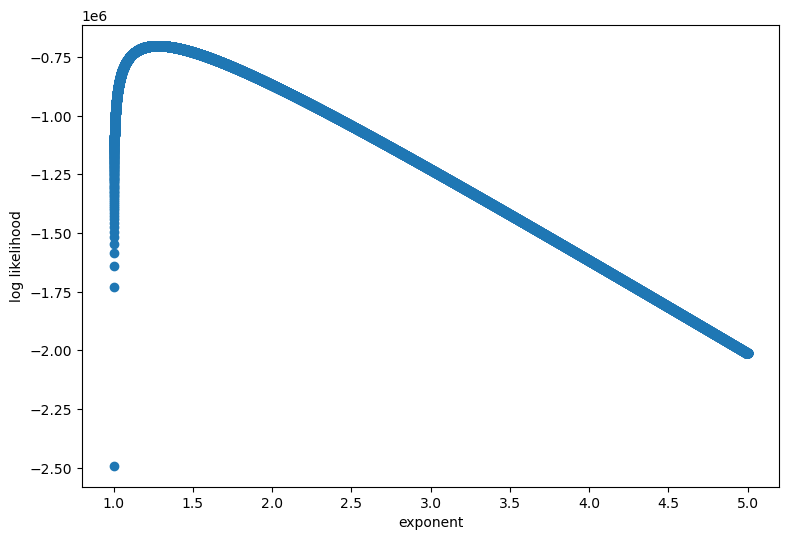

best exponent out of  100000 is 1.28, ll -7.01e+05


In [57]:
test_exp_min = guess_min
test_exp_max = 5# guess_max
num_test_values = 100000
test_exponents = torch.linspace(start=test_exp_min, end=test_exp_max, steps=num_test_values, dtype=float_type, device=device)
test_log_likelihoods = -total_count_from_x_min * torch.log( torch.special.zeta(test_exponents, x_min) ) - test_exponents * total_sum_of_logs_from_x_min
make_scatter(xname='exponent', xvalues=test_exponents, yname='log likelihood', yvalues=test_log_likelihoods)
test_best_index = torch.argmax(test_log_likelihoods)
print(f'best exponent out of  {num_test_values} is {test_exponents[test_best_index]:.3g}, ll {test_log_likelihoods[test_best_index]:.3g}')

In [58]:
print(f'searching for exponent that gives highest finite log likelihood for x_min {x_min:.3g}...')
# We assume that the function is smooth and concave downward so that we do not need to worry about being caught in local maxima.
best_exponent = guess_min
best_log_likelihood = -total_count_from_x_min * torch.log( torch.special.zeta(best_exponent, x_min) ) - best_exponent * total_sum_of_logs_from_x_min
for pass_index in range(num_passes):
    print(f'pass {pass_index+1} [{guess_min:.3g}, {guess_max:.3g}], best {best_exponent:.3g}, ll {best_log_likelihood:.3g}')
    best_exponent_this_pass = guess_min
    best_log_likelihood_this_pass = -total_count_from_x_min * torch.log( torch.special.zeta(best_exponent_this_pass, x_min) ) - best_exponent_this_pass * total_sum_of_logs_from_x_min
    for try_exponent in torch.linspace(start=guess_min, end=guess_max, steps=num_tries_per_pass, dtype=float_type, device=device):
        try_log_likelihood = -total_count_from_x_min * torch.log( torch.special.zeta(try_exponent, x_min) ) - try_exponent * total_sum_of_logs_from_x_min
        print(f'try exponent {try_exponent:.3g}, ll {try_log_likelihood:.3g}')
        if try_log_likelihood > best_log_likelihood:
            best_exponent = try_exponent
            best_log_likelihood = try_log_likelihood
        if try_log_likelihood >= best_log_likelihood_this_pass:
            guess_min = best_exponent_this_pass
            best_exponent_this_pass = try_exponent
            best_log_likelihood_this_pass = try_log_likelihood
        else:
            guess_max = try_exponent
            break
print(f'final [{guess_min:.3g}, {guess_max:.3g}], best on final pass {best_exponent_this_pass:.3g}, ll {best_log_likelihood_this_pass:.3g}, best overall {best_exponent:.3g}, ll {best_log_likelihood:.3g}')

searching for exponent that gives highest finite log likelihood for x_min 1...
pass 1 [1, 24], best 1, ll -2.49e+06
try exponent 1, ll -2.49e+06
try exponent 3.56, ll -1.44e+06
try exponent 6.11, ll -2.46e+06
pass 2 [1, 6.11], best 3.56, ll -1.44e+06
try exponent 1, ll -2.49e+06
try exponent 1.57, ll -7.43e+05
try exponent 2.14, ll -9.14e+05
pass 3 [1, 2.14], best 1.57, ll -7.43e+05
try exponent 1, ll -2.49e+06
try exponent 1.13, ll -7.33e+05
try exponent 1.25, ll -7.02e+05
try exponent 1.38, ll -7.08e+05
pass 4 [1.13, 1.38], best 1.25, ll -7.02e+05
try exponent 1.13, ll -7.33e+05
try exponent 1.15, ll -7.2e+05
try exponent 1.18, ll -7.11e+05
try exponent 1.21, ll -7.06e+05
try exponent 1.24, ll -7.03e+05
try exponent 1.27, ll -7.01e+05
try exponent 1.29, ll -7.02e+05
pass 5 [1.24, 1.29], best 1.27, ll -7.01e+05
try exponent 1.24, ll -7.03e+05
try exponent 1.24, ll -7.02e+05
try exponent 1.25, ll -7.02e+05
try exponent 1.26, ll -7.02e+05
try exponent 1.26, ll -7.02e+05
try exponent 1.2

In [59]:
approx_exponent = 1 + total_count_from_x_min/( total_sum_of_logs_from_x_min - total_count_from_x_min * torch.log(x_min - 0.5) )
approx_log_likelihood = -total_count_from_x_min * torch.log( torch.special.zeta(approx_exponent, x_min) ) - approx_exponent * total_sum_of_logs_from_x_min
print(f'continuous case approximation exponent {approx_exponent:.3g} log likelihood {approx_log_likelihood:.3g}')

continuous case approximation exponent 1.27 log likelihood -7.01e+05


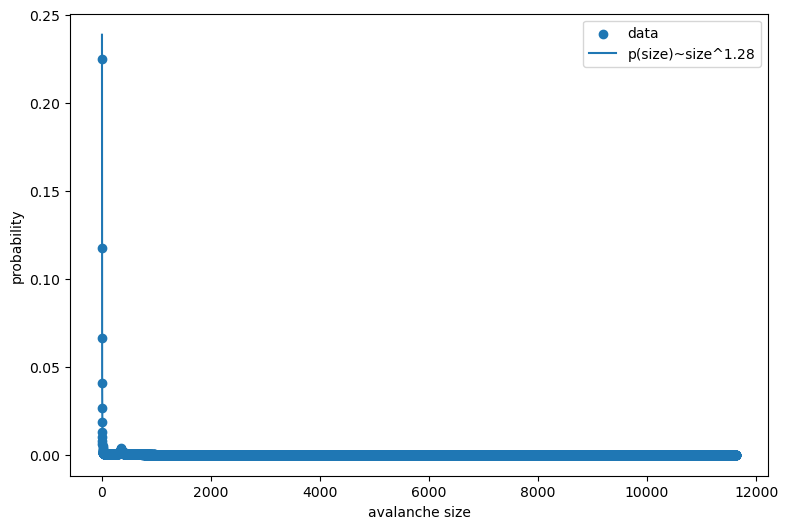

In [60]:
size_probs_data = size_counts[threshold_index,:] / size_counts[threshold_index,:].sum(dim=-1, keepdim=True)
size_probs_power_law = torch.pow(sizes, -1*best_exponent)/torch.special.zeta(best_exponent,x_min)
make_scatter_and_line(xname='avalanche size', xvalues=sizes, yname='probability', scatter_label='data', y_scatter_values=size_probs_data, line_label=f'p(size)~size^{best_exponent:.3g}', y_line_values=size_probs_power_law)

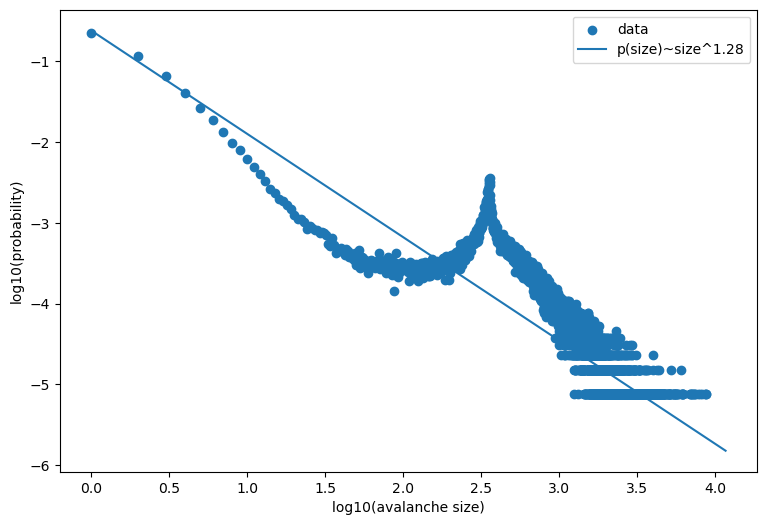

In [61]:
make_scatter_and_line(xname='log10(avalanche size)', xvalues=sizes.log10(), yname='log10(probability)', scatter_label='data', y_scatter_values=size_probs_data.log10(), line_label=f'p(size)~size^{best_exponent:.3g}', y_line_values=size_probs_power_law.log10() )

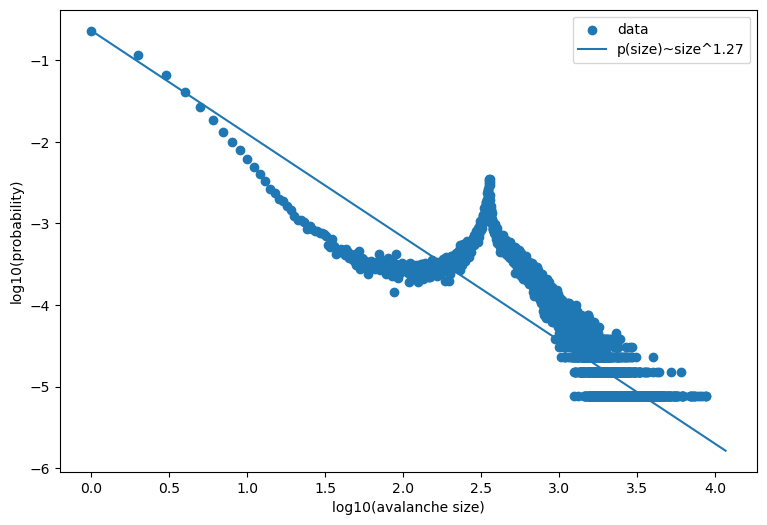

In [62]:
size_probs_power_law_approx = torch.pow(sizes, -1*approx_exponent)/torch.special.zeta(approx_exponent,x_min)
make_scatter_and_line(xname='log10(avalanche size)', xvalues=sizes.log10(), yname='log10(probability)', scatter_label='data', y_scatter_values=size_probs_data.log10(), line_label=f'p(size)~size^{approx_exponent:.3g}', y_line_values=size_probs_power_law_approx.log10() )

The distribution of The distribution of FC correlations after 10000 steps of individidual training values has median 0.907 with 95% CI [0.509, 0.95] and range [-0.0173, 0.972].
The distribution of The distribution of FC correlations after 20000 steps of individidual training values has median 0.955 with 95% CI [0.785, 0.973] and range [0.176, 0.985].
The distribution of The distribution of FC correlations after 10000 steps of group training and 10000 steps of individidual training values has median 0.956 with 95% CI [0.89, 0.974] and range [0.152, 0.986].
The distribution of The distribution of FC correlations after 38000 steps of individidual training values has median 0.975 with 95% CI [0.925, 0.986] and range [0.654, 0.991].


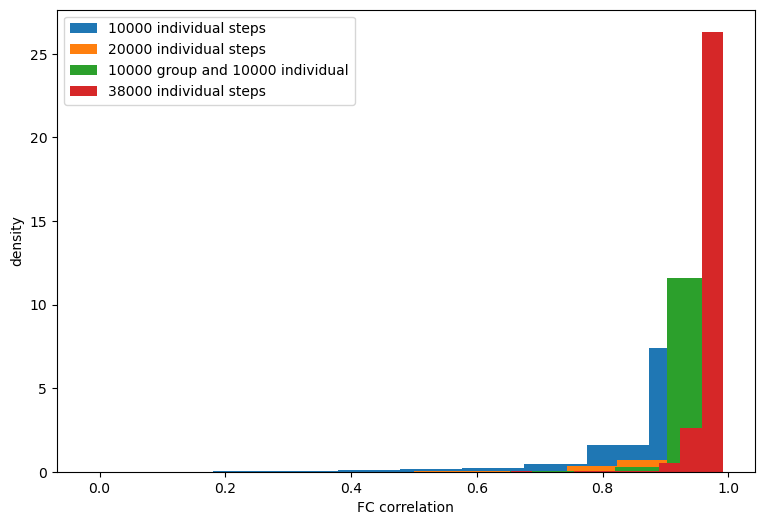

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

threshold = 1
beta_opt_length = 68
max_num_updates = 38000

def print_individual_only(param_opt_length:int):
    fc_corr_file = os.path.join( file_dir, f'fc_corr_all_mean_std_{threshold:.3g}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_{beta_opt_length}_popt_steps_{param_opt_length}_test_length_120000.pt' )
    fc_corr = torch.load(fc_corr_file)
    # print( 'fc_corr size', fc_corr.size() )
    fc_corr = fc_corr[:,training_index_start:training_index_end]
    # print( 'fc_corr size', fc_corr.size() )
    axs.hist( depytorch(fc_corr).flatten(), label=f'{param_opt_length} individual steps', density=True )
    print_stats(name=f'The distribution of FC correlations after {param_opt_length} steps of individidual training', values=fc_corr)

print_individual_only(10000)
print_individual_only(20000)

fc_corr_file = os.path.join(file_dir, 'fc_corr_individual_mean_std_1_models_8370_lr_0.01_sim_steps_1.2e+03_plupdates_0_minb_0.008_maxb_0.015_betaopt_10000_simupdates_10000_test_length_120000.pt')
fc_corr = torch.load(fc_corr_file)
# print( 'fc_corr size', fc_corr.size() )
fc_corr = fc_corr[:,training_index_start:training_index_end]
axs.hist( depytorch(fc_corr).flatten(), label=f'10000 group and 10000 individual', density=True )
print_stats(name=f'The distribution of FC correlations after 10000 steps of group training and 10000 steps of individidual training', values=fc_corr)

print_individual_only(max_num_updates)

# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('FC correlation')
axs.set_ylabel('density')
# axs.set_title(f'distribution of {xlabel}')
axs.legend()
plt.show()

The distribution of The distribution of FC correlations after 10000 steps of individidual training values has median 0.992 with 95% CI [0.969, 0.996] and range [0.896, 0.998].
The distribution of The distribution of FC correlations after 20000 steps of individidual training values has median 0.993 with 95% CI [0.964, 0.998] and range [0.833, 0.999].
The distribution of The distribution of FC correlations after 34000 steps of individidual training values has median 0.993 with 95% CI [0.958, 0.998] and range [0.838, 0.999].


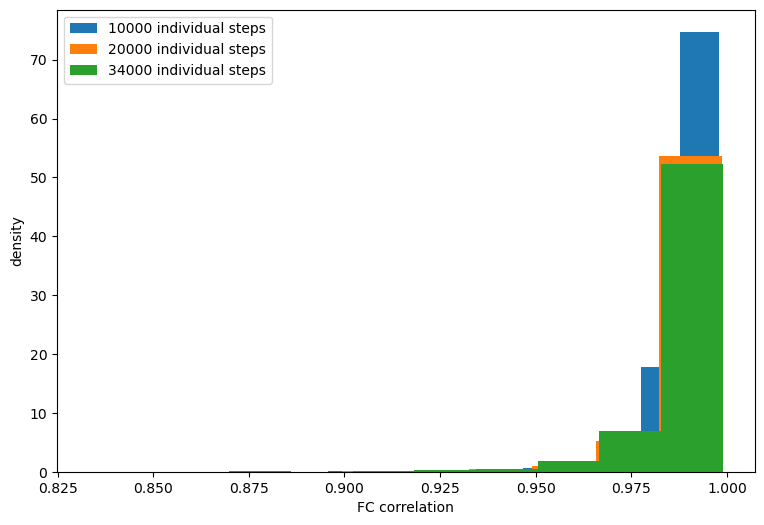

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

threshold = 0
beta_opt_length = 66
max_num_updates = 34000

def print_individual_only(param_opt_length:int):
    fc_corr_file = os.path.join( file_dir, f'fc_corr_all_mean_std_{threshold:.3g}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_{beta_opt_length}_popt_steps_{param_opt_length}_test_length_120000.pt' )
    fc_corr = torch.load(fc_corr_file)
    # print( 'fc_corr size', fc_corr.size() )
    fc_corr = fc_corr[:,training_index_start:training_index_end]
    # print( 'fc_corr size', fc_corr.size() )
    axs.hist( depytorch(fc_corr).flatten(), label=f'{param_opt_length} individual steps', density=True )
    print_stats(name=f'The distribution of FC correlations after {param_opt_length} steps of individidual training', values=fc_corr)

print_individual_only(10000)
print_individual_only(20000)

# fc_corr_file = os.path.join(file_dir, 'fc_corr_individual_mean_std_1_models_8370_lr_0.01_sim_steps_1.2e+03_plupdates_0_minb_0.008_maxb_0.015_betaopt_10000_simupdates_10000_test_length_120000.pt')
# fc_corr = torch.load(fc_corr_file)
# print( 'fc_corr size', fc_corr.size() )
# fc_corr = fc_corr[:,training_index_start:training_index_end]
# axs.hist( depytorch(fc_corr).flatten(), label=f'10000 group and 10000 individual', density=True )
# print_stats(name=f'The distribution of FC correlations after 10000 steps of group training and 10000 steps of individidual training', values=fc_corr)

print_individual_only(max_num_updates)

# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('FC correlation')
axs.set_ylabel('density')
# axs.set_title(f'distribution of {xlabel}')
axs.legend()
plt.show()

test CDF tensor([1.0000, 0.3921, 0.2401, 0.1725, 0.1345, 0.1102, 0.0933, 0.0809, 0.0714],
       device='cuda:0') tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006],
       device='cuda:0')
min mean max of uniform sample: 0.00011985504534095526 0.5047439932823181 0.9999439716339111
test sample CDF bin index range tensor(0, device='cuda:0') tensor(866, device='cuda:0')
sample counts tensor([6133, 1516,  670,  339,  237,  184,  138,   84,   65], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
total test sample counts tensor(9996, device='cuda:0')
empirical probabilities tensor([0.6135, 0.1517, 0.0670, 0.0339, 0.0237, 0.0184, 0.0138, 0.0084, 0.0065],
       device='cuda:0') tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
empirical CDF tensor([1.0000, 0.3865, 0.2348, 0.1678, 0.1339, 0.1101, 0.0917, 0.0779, 0.0695],
       device='cuda:0') tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
KS distance tensor(0.0056,

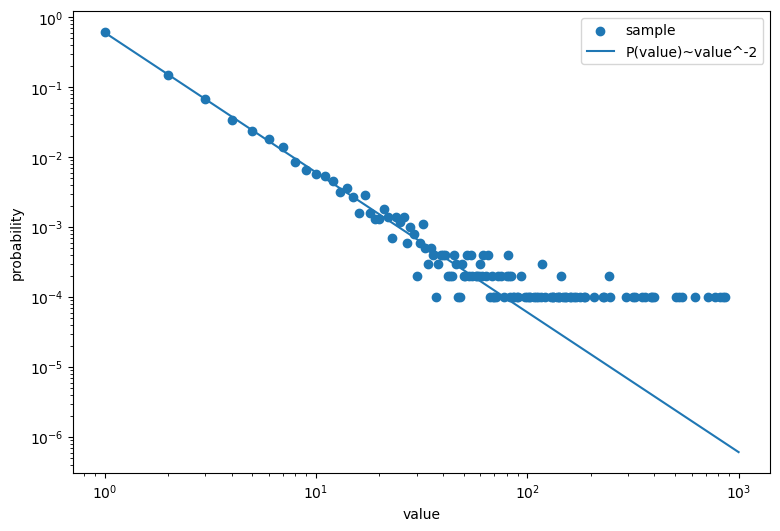

In [65]:
test_exponent = torch.tensor(data=[2.0], dtype=float_type, device=device)
max_test_value = 1000
test_values = torch.arange(start=1, end=max_test_value+1, dtype=float_type, device=device)
test_total_zeta = torch.special.zeta( test_exponent, 1 )
test_cdf = torch.special.zeta( test_exponent, test_values )/test_total_zeta
print( 'test CDF', test_cdf[:9], test_cdf[-9:] )
# print( test_cdf[:9], test_cdf[-9:] )
test_samples_uniform = torch.rand( size=(10000,), dtype=float_type, device=device )
print( 'min mean max of uniform sample:', test_samples_uniform.min().item(), test_samples_uniform.mean().item(), test_samples_uniform.max().item() )
is_under_threshold = test_samples_uniform.unsqueeze(dim=1) < test_cdf.unsqueeze(dim=0)
is_less_than_or_equal_to_max = test_samples_uniform.unsqueeze(dim=1) >= test_cdf[-1]
test_sample_cdf_bin_index = torch.count_nonzero( torch.logical_and(is_under_threshold, is_less_than_or_equal_to_max), dim=1 )
print( 'test sample CDF bin index range', test_sample_cdf_bin_index.min(), test_sample_cdf_bin_index.max() )
# Discard the last bin and the value, since the bin contains all points that were greater than the last bin edge.
# test_sample_values = test_values[test_sample_cdf_bin_index]
# print( test_sample_values.size() )
test_sample_counts = torch.count_nonzero( test_values.unsqueeze(dim=1) == test_sample_cdf_bin_index.unsqueeze(dim=0), dim=1 )
print( 'sample counts', test_sample_counts[0:9], test_sample_counts[-9:] )
print( 'total test sample counts', test_sample_counts.sum() )
# print( test_sample_counts.sum() )
test_sample_probs = test_sample_counts/test_sample_counts.sum()
print( 'empirical probabilities', test_sample_probs[:9], test_sample_probs[-9:] )
test_sample_cdf = torch.flip(   torch.cumsum(  torch.flip( test_sample_probs, dims=(0,) ), dim=0  ), dims=(0,)   )
print( 'empirical CDF', test_sample_cdf[:9], test_sample_cdf[-9:] )
# print( test_sample_cdf[:9], test_sample_cdf[-9:] )
print(  'KS distance', torch.max( torch.abs(test_cdf - test_sample_cdf) )  )
test_ideal_probs = torch.pow( test_values, -test_exponent )/test_total_zeta
print( 'ideal probabilities', test_ideal_probs[:9], test_ideal_probs[-9:] )
make_scatter_and_line(xname='value', xvalues=test_values, yname='probability', scatter_label='sample', y_scatter_values=test_sample_probs, line_label=f'P(value)~value^-{test_exponent.item():.3g}', y_line_values=test_ideal_probs, do_log_log=True)

test CDF tensor([1.0000, 0.3921, 0.2401, 0.1725, 0.1345, 0.1102, 0.0933, 0.0809, 0.0714],
       device='cuda:0') tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006],
       device='cuda:0')
is decreasing tensor([True, True, True, True, True, True, True, True, True], device='cuda:0') tensor([True, True, True, True, True, True, True, True, True], device='cuda:0')
min mean max of uniform sample: 3.853312227874994e-05 0.5006623864173889 0.9999969601631165
test sample CDF bin index range tensor(1, device='cuda:0') tensor(1000, device='cuda:0')
sample counts tensor([60867, 15006,  6813,  3742,  2426,  1731,  1257,   948,   752],
       device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
total test sample counts tensor(99999, device='cuda:0')
empirical probabilities tensor([0.6087, 0.1501, 0.0681, 0.0374, 0.0243, 0.0173, 0.0126, 0.0095, 0.0075],
       device='cuda:0') tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
KS distance tens

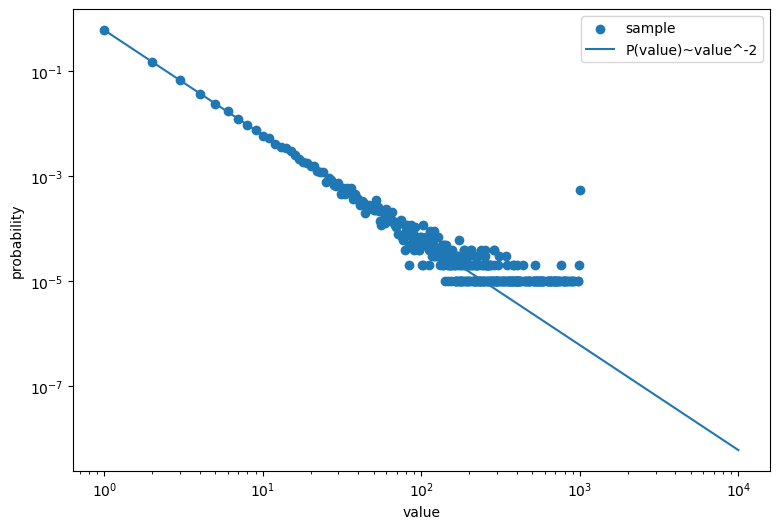

In [66]:
test_exponent = torch.tensor(data=[2.0], dtype=float_type, device=device)
max_test_value = 10000
test_values = torch.arange(start=1, end=max_test_value+2, dtype=float_type, device=device)
test_total_zeta = torch.special.zeta( test_exponent, 1 )
print( 'test CDF', test_cdf[:9], test_cdf[-9:] )
is_decreasing = test_cdf[:-1] > test_cdf[1:]
print( 'is decreasing', is_decreasing[:9], is_decreasing[-9:] )
# print( test_cdf[:9], test_cdf[-9:] )
test_samples_uniform = torch.rand( size=(100000,), dtype=float_type, device=device )
print( 'min mean max of uniform sample:', test_samples_uniform.min().item(), test_samples_uniform.mean().item(), test_samples_uniform.max().item() )
test_sample_cdf_bin_index = torch.count_nonzero( test_samples_uniform.unsqueeze(dim=1) <= test_cdf.unsqueeze(dim=0), dim=1 )
print( 'test sample CDF bin index range', test_sample_cdf_bin_index.min(), test_sample_cdf_bin_index.max() )
# Discard the last bin and the value, since the bin contains all points that were greater than the last bin edge.
test_values = test_values[:-1]
test_sample_cdf_bin_index = test_sample_cdf_bin_index[:-1]
# test_sample_values = test_values[test_sample_cdf_bin_index]
# print( test_sample_values.size() )
test_sample_counts = torch.count_nonzero( test_values.unsqueeze(dim=1) == test_sample_cdf_bin_index.unsqueeze(dim=0), dim=1 )
print( 'sample counts', test_sample_counts[0:9], test_sample_counts[-9:] )
print( 'total test sample counts', test_sample_counts.sum() )
# print( test_sample_counts.sum() )
test_sample_probs = test_sample_counts/test_sample_counts.sum()
print( 'empirical probabilities', test_sample_probs[:9], test_sample_probs[-9:] )
test_sample_cdf = torch.flip(   torch.cumsum(  torch.flip( test_sample_probs, dims=(0,) ), dim=0  ), dims=(0,)   )
test_cdf = torch.special.zeta( test_exponent, test_values )/test_total_zeta
# print( test_sample_cdf[:9], test_sample_cdf[-9:] )
print(  'KS distance', torch.max( torch.abs(test_cdf - test_sample_cdf) )  )
test_ideal_probs = torch.pow( test_values, -test_exponent )/test_total_zeta
print( 'ideal probabilities', test_ideal_probs[:9], test_ideal_probs[-9:] )
make_scatter_and_line(xname='value', xvalues=test_values, yname='probability', scatter_label='sample', y_scatter_values=test_sample_probs, line_label=f'P(value)~value^-{test_exponent.item():.3g}', y_line_values=test_ideal_probs, do_log_log=True)

test_values size torch.Size([11632])
test CDF tensor([1.0000, 0.7613, 0.6629, 0.6043, 0.5637, 0.5332, 0.5091, 0.4892, 0.4725],
       device='cuda:0') tensor([0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633, 0.0633],
       device='cuda:0')
is decreasing tensor([True, True, True, True, True, True, True, True, True], device='cuda:0') tensor([True, True, True, True, True, True, True, True, True], device='cuda:0')
min mean max of uniform sample: 3.4290249459445477e-05 0.500796914100647 0.9999993443489075
test sample CDF bin index range tensor(6341, device='cuda:0') tensor(100000, device='cuda:0')
sample counts tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([1, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
total test sample counts tensor(10308, device='cuda:0')
empirical probabilities tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0') tensor([9.7012e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7012e-05, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 9.7012e-05

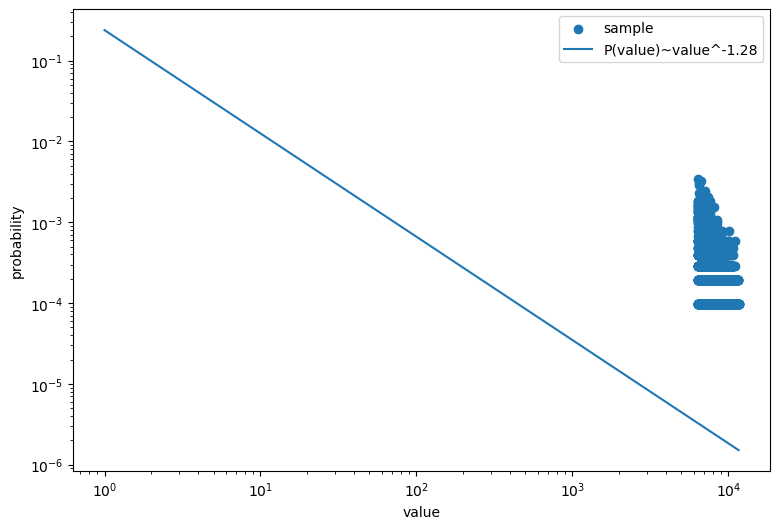

In [69]:
test_exponent = best_exponent# torch.tensor(data=[2.0], dtype=float_type, device=device)
max_test_value = sizes.max()
test_values = sizes
print( 'test_values size', test_values.size() )
test_total_zeta = torch.special.zeta( test_exponent, 1 )
test_cdf = test_cdf = torch.special.zeta( test_exponent, test_values )/test_total_zeta
print( 'test CDF', test_cdf[:9], test_cdf[-9:] )
is_decreasing = test_cdf[:-1] > test_cdf[1:]
print( 'is decreasing', is_decreasing[:9], is_decreasing[-9:] )
# print( test_cdf[:9], test_cdf[-9:] )
test_samples_uniform = torch.rand( size=(100000,), dtype=float_type, device=device )
print( 'min mean max of uniform sample:', test_samples_uniform.min().item(), test_samples_uniform.mean().item(), test_samples_uniform.max().item() )
test_sample_cdf_bin_index = torch.cat([torch.count_nonzero( test_samples_uniform <= test_cdf[i] ).unsqueeze(dim=0) for i in range( test_cdf.numel() )], dim=0)
# test_sample_cdf_bin_index = torch.count_nonzero( test_samples_uniform.unsqueeze(dim=1) <= test_cdf.unsqueeze(dim=0), dim=1 )
print( 'test sample CDF bin index range', test_sample_cdf_bin_index.min(), test_sample_cdf_bin_index.max() )
# Discard the last bin and the value, since the bin contains all points that were greater than the last bin edge.
test_values = test_values[:-1]
test_sample_cdf_bin_index = test_sample_cdf_bin_index[:-1]
# test_sample_values = test_values[test_sample_cdf_bin_index]
# print( test_sample_values.size() )
# test_sample_counts = torch.cat([torch.count_nonzero(test_values[i] == test_sample_cdf_bin_index) for i in range( test_values.numel() )], dim=0)
test_sample_counts = torch.count_nonzero( test_values.unsqueeze(dim=1) == test_sample_cdf_bin_index.unsqueeze(dim=0), dim=1 )
print( 'sample counts', test_sample_counts[0:9], test_sample_counts[-9:] )
print( 'total test sample counts', test_sample_counts.sum() )
# print( test_sample_counts.sum() )
test_sample_probs = test_sample_counts/test_sample_counts.sum()
print( 'empirical probabilities', test_sample_probs[:9], test_sample_probs[-9:] )
test_sample_cdf = torch.flip(   torch.cumsum(  torch.flip( test_sample_probs, dims=(0,) ), dim=0  ), dims=(0,)   )
test_cdf = torch.special.zeta( test_exponent, test_values )/test_total_zeta
# print( test_sample_cdf[:9], test_sample_cdf[-9:] )
print(  'KS distance', torch.max( torch.abs(test_cdf - test_sample_cdf) )  )
test_ideal_probs = torch.pow( test_values, -test_exponent )/test_total_zeta
print( 'ideal probabilities', test_ideal_probs[:9], test_ideal_probs[-9:] )
make_scatter_and_line(xname='value', xvalues=test_values, yname='probability', scatter_label='sample', y_scatter_values=test_sample_probs, line_label=f'P(value)~value^-{test_exponent.item():.3g}', y_line_values=test_ideal_probs, do_log_log=True)

num_samples 67657528
samples tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0') tensor([1.0847e+24, 1.2254e+24, 1.2347e+24, 2.3756e+24, 7.2297e+24, 1.3976e+25,
        3.4292e+25, 5.8715e+25, 8.6578e+26], device='cuda:0')
sample_cdf tensor([0.0000e+00, 1.4780e-08, 2.9561e-08, 4.4341e-08, 5.9121e-08, 7.3902e-08,
        8.8682e-08, 1.0346e-07, 1.1824e-07], device='cuda:0') tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
power_law_cdf tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0') tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
KS distance 0.175


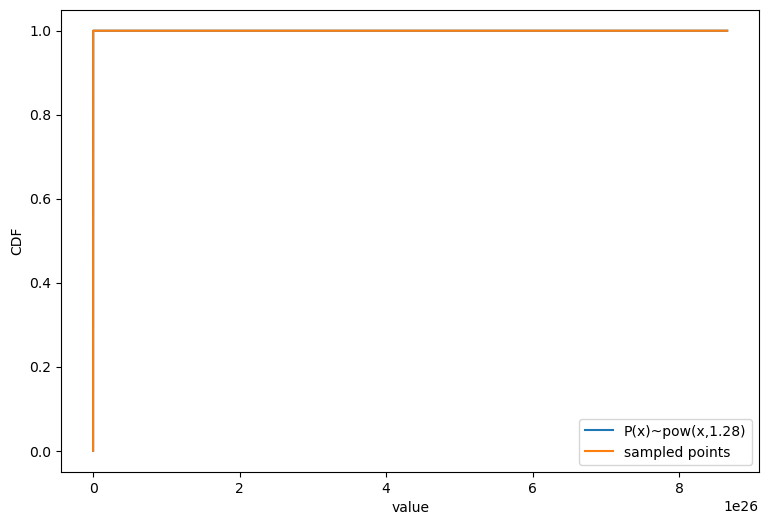

In [79]:
test_exponent = best_exponent
num_samples = sizes.sum().int()
print(f'num_samples {num_samples}')
samples = torch.tensor(  data=np.random.pareto( test_exponent.item()-1, num_samples ), dtype=test_exponent.dtype, device=test_exponent.device  ).sort().values.ceil()
print( 'samples', samples[:9], samples[-9:] )
sample_cdf = torch.linspace(start=0, end=1, steps=num_samples, dtype=samples.dtype, device=samples.device)
print( 'sample_cdf', sample_cdf[:9], sample_cdf[-9:] )
power_law_cdf = 1 - torch.special.zeta(test_exponent, samples)/torch.special.zeta(test_exponent, 1)
print( 'power_law_cdf', power_law_cdf[:9], power_law_cdf[-9:] )
ks_distance = torch.max( torch.abs(sample_cdf-power_law_cdf) )
print(f'KS distance {ks_distance:.3g}')

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.plot( depytorch(samples), depytorch(power_law_cdf), label=f'P(x)~pow(x,{test_exponent:.3g})' )
axs.plot( depytorch(samples), depytorch(sample_cdf), label=f'sampled points' )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
# axs.set_xscale('log')
# axs.set_yscale('log')
axs.set_xlabel('value')
axs.set_ylabel('CDF')
# axs.set_title(f'{xname} vs {yname}')
axs.legend()